# Trabalho A2 - Análise de Séries Temporais

## Bibliotecas

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sklearn.model_selection import TimeSeriesSplit
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, MeanAbsoluteScaledError,
)

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from IPython.display import display

import itertools

## Dados

In [111]:
prison = pd.read_csv("data_updated.csv")

In [112]:
prison

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648
...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575
153,2025-10-06,14.50,0.520285,4.504
154,2025-10-13,17.89,0.837998,7.296
155,2025-10-20,24.52,1.422242,12.458


In [113]:
# Converte a coluna "week" para datetime
prison["week"] = pd.to_datetime(prison["week"])

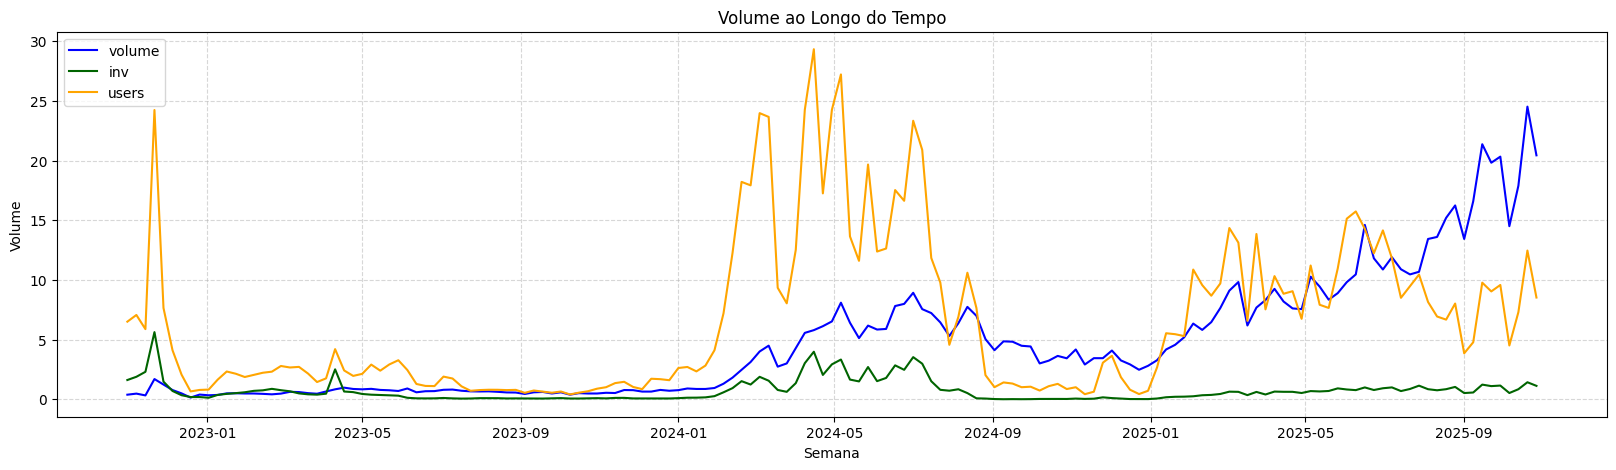

In [114]:
# Criar o gráfico
plt.figure(figsize=(20, 5))
plt.plot(prison["week"], prison["volume"], linestyle="-", marker="", color="blue", label="volume")
plt.plot(prison["week"], prison["inv"], linestyle="-", marker="", color="darkgreen", label="inv")
plt.plot(prison["week"], prison["users"], linestyle="-", marker="", color="orange", label="users")

# Labels e título
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.title("Volume ao Longo do Tempo")
plt.legend(loc="upper left")

# Estilo minimalista
plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
plt.show()

Plots de cada variável separada

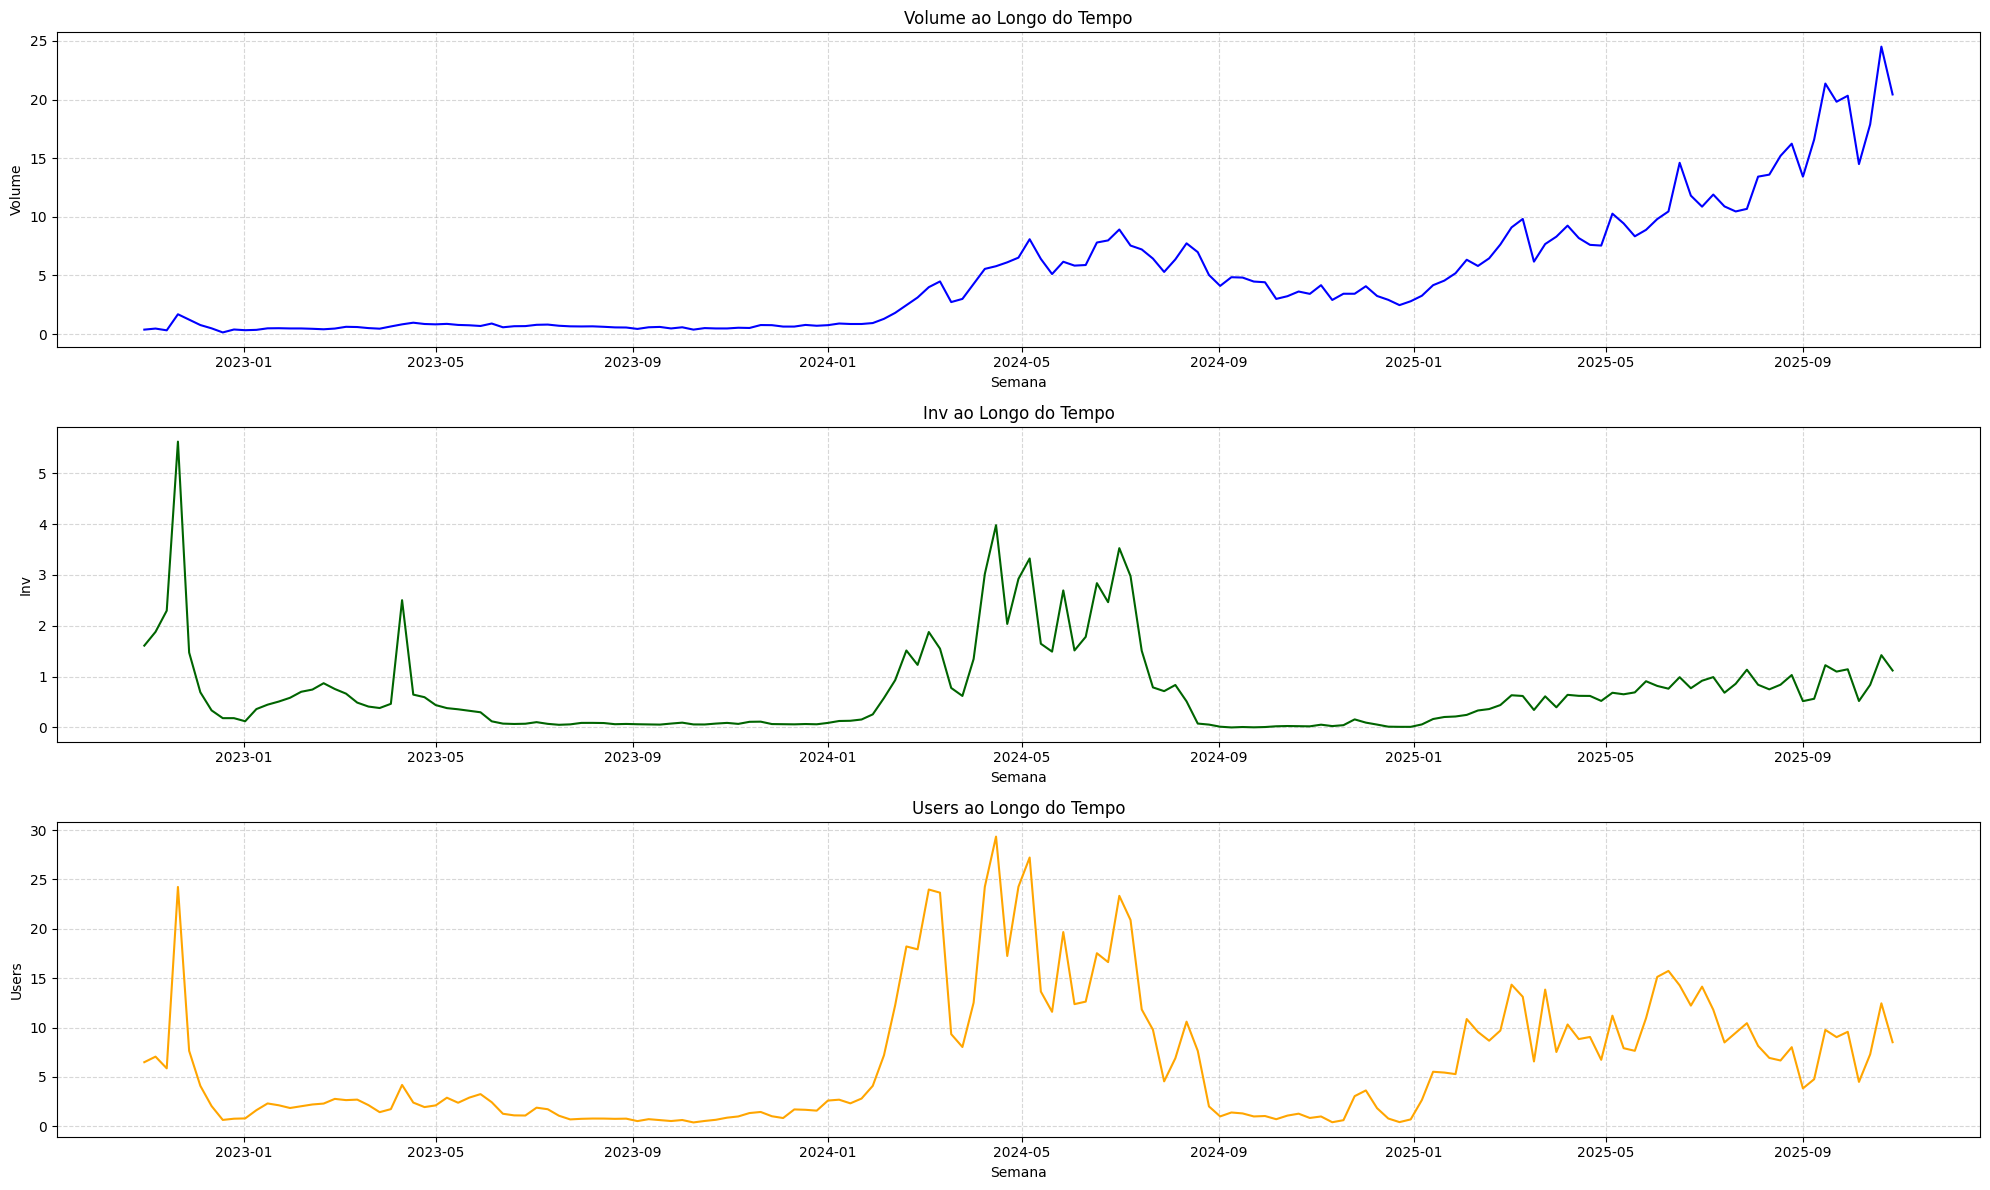

In [115]:
colors = ["blue", "darkgreen", "orange"]
columns = prison.columns

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i in range(3):
    ax = axes[i]
    column = columns[i + 1]

    ax.plot(prison["week"], prison[column], linestyle="-", marker="", color=colors[i])

    # Labels e título
    ax.set_xlabel("Semana")
    ax.set_ylabel(column.title())
    ax.set_title(f"{column.title()} ao Longo do Tempo")

    # Estilo minimalista
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## Após Aplicação da Transformação Box-Cox na Variável Volume


In [116]:
prison = prison.set_index("week")
y = prison["volume"]

y_bc, lmbda = boxcox(y)

print(f"O valor de lambda (λ) é: {lmbda:.4f}")


O valor de lambda (λ) é: 0.0381


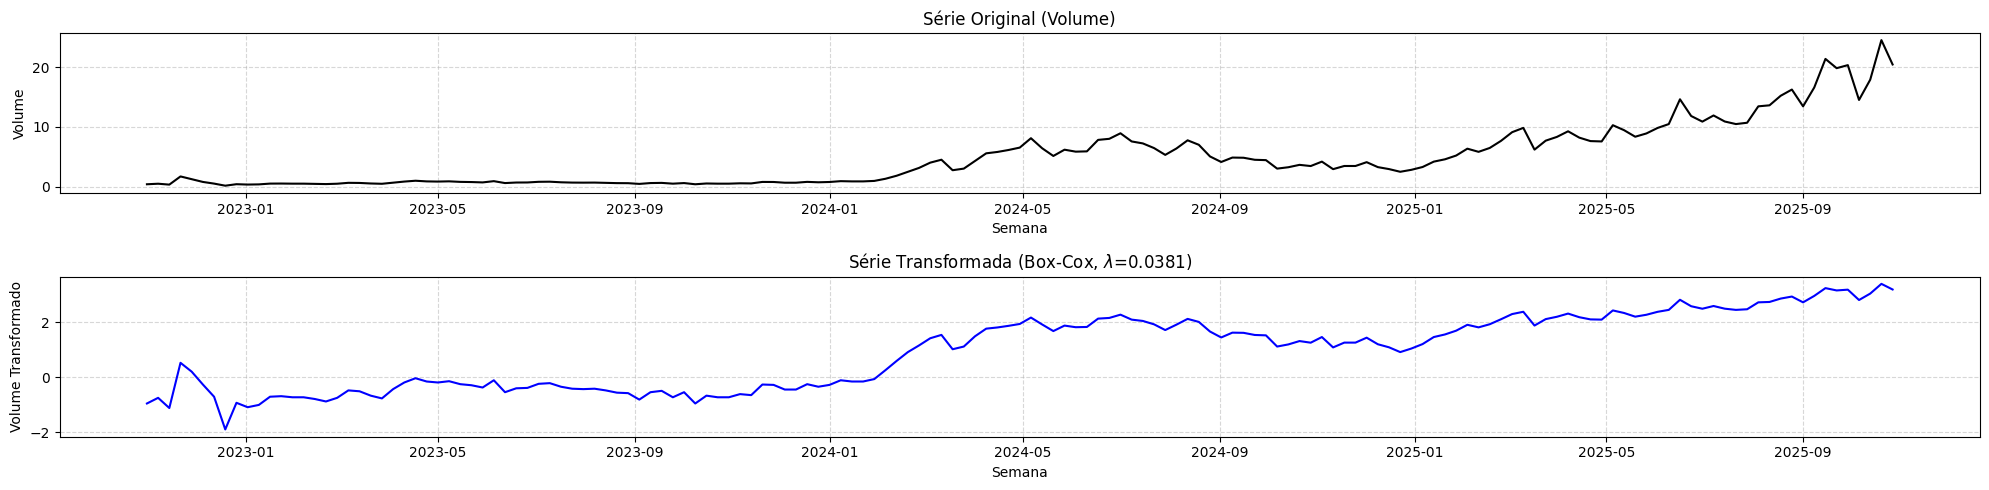

In [117]:
# Armazena a série transformada no DataFrame para futuras modelagens
prison["volume_bc"] = y_bc

# Criar o gráfico
fig, axes = plt.subplots(2, 1, figsize=(20, 5))

# Série Original
axes[0].plot(prison["volume"], linestyle="-", color="black")
axes[0].set_title("Série Original (Volume)")
axes[0].set_ylabel("Volume")
axes[0].set_xlabel("Semana")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Série Transformada
axes[1].plot(prison["volume_bc"], linestyle="-", color="blue")
axes[1].set_title(f"Série Transformada (Box-Cox, $\\lambda$={lmbda:.4f})")
axes[1].set_ylabel("Volume Transformado")
axes[1].set_xlabel("Semana")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


## Transformação nas Covariáveis `inv` e `users`


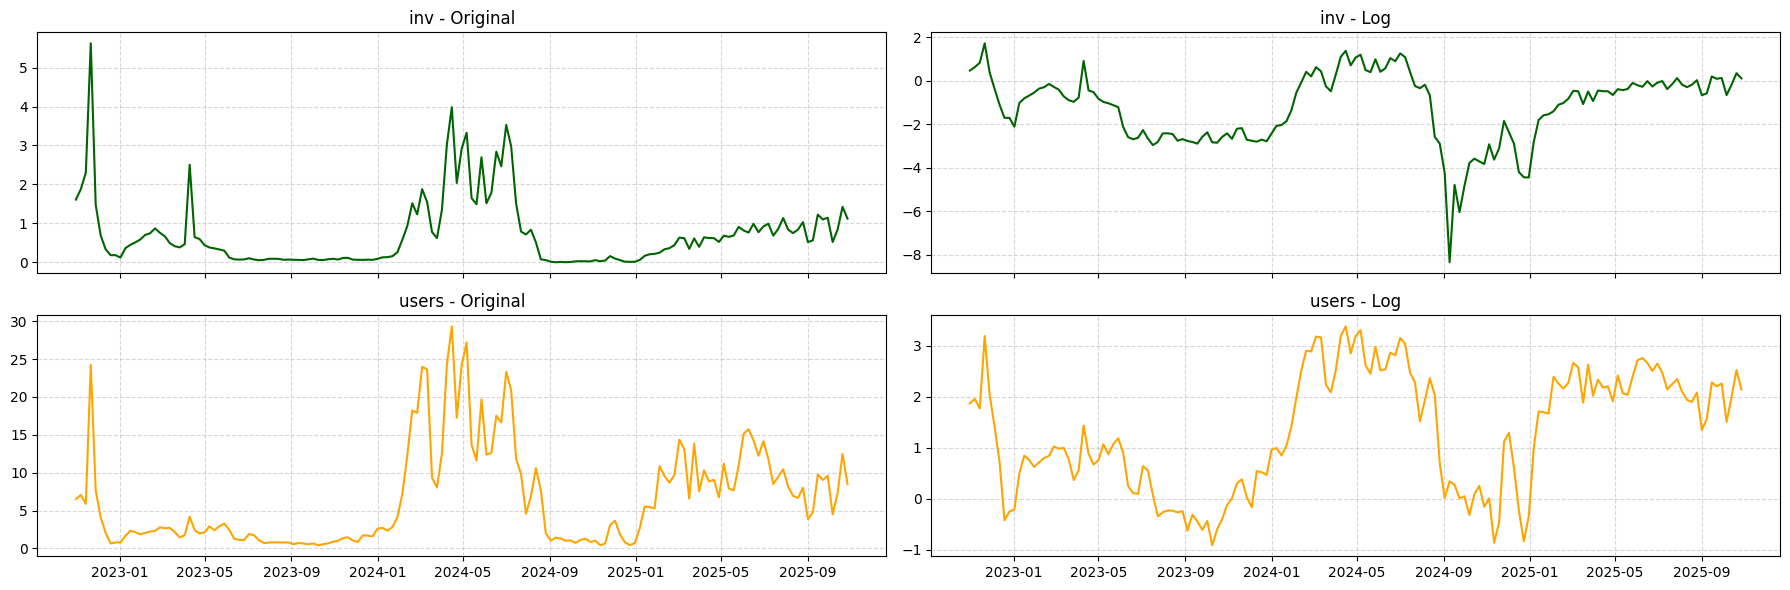

In [118]:
# Transformação log (usando log1p para evitar problemas com valores iguais a zero)
prison["inv_log"] = np.log(prison["inv"])
prison["users_log"] = np.log(prison["users"])

# Comparando original x log-transformada
fig, axes = plt.subplots(2, 2, figsize=(18, 6), sharex=True)

axes[0, 0].plot(prison.index, prison["inv"], color="darkgreen")
axes[0, 0].set_title("inv - Original")
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

axes[0, 1].plot(prison.index, prison["inv_log"], color="darkgreen")
axes[0, 1].set_title("inv - Log")
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

axes[1, 0].plot(prison.index, prison["users"], color="orange")
axes[1, 0].set_title("users - Original")
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

axes[1, 1].plot(prison.index, prison["users_log"], color="orange")
axes[1, 1].set_title("users - Log")
axes[1, 1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


# Decomposição STL

In [119]:
series_orig = prison["volume"].asfreq(pd.infer_freq(prison.index) or "W")
stl_orig = STL(series_orig, period=52, robust=True).fit()

In [120]:
series_bc = prison["volume_bc"].asfreq(pd.infer_freq(prison.index) or "W")
stl_bc = STL(series_bc, period=52, robust=True).fit()

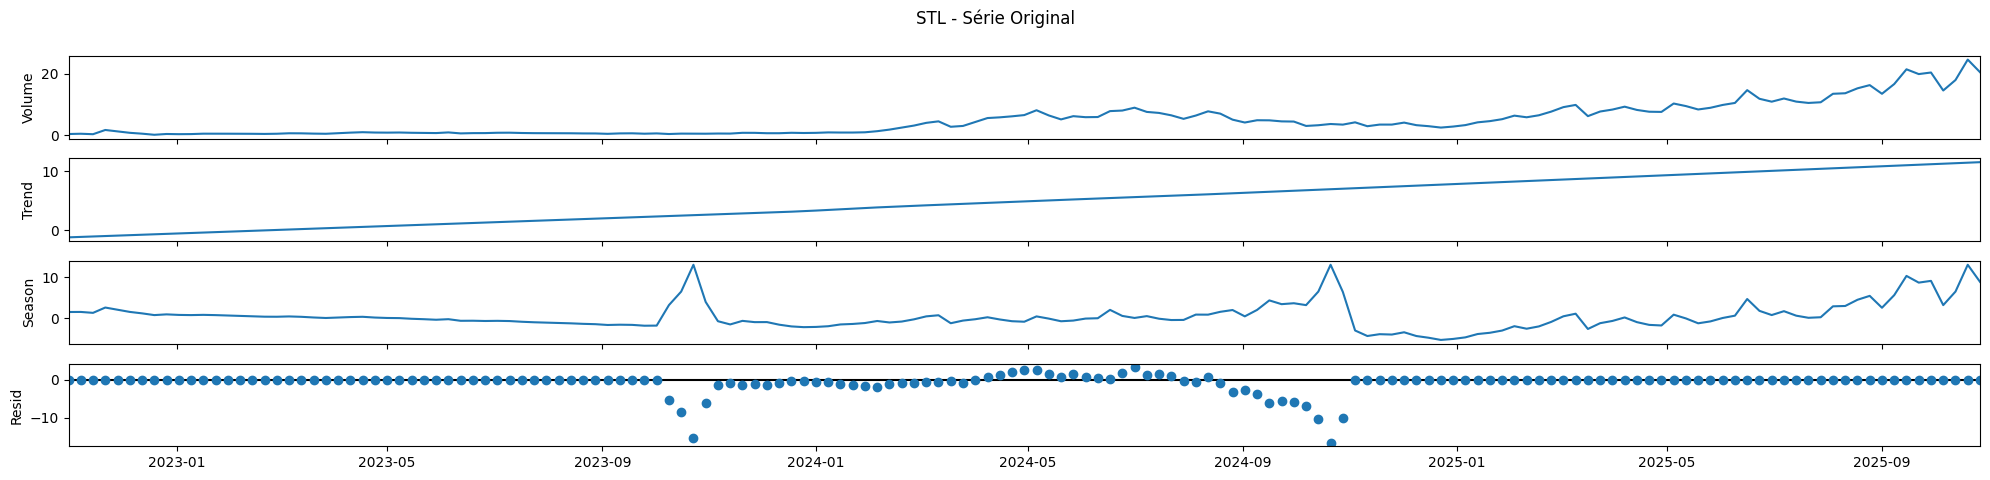

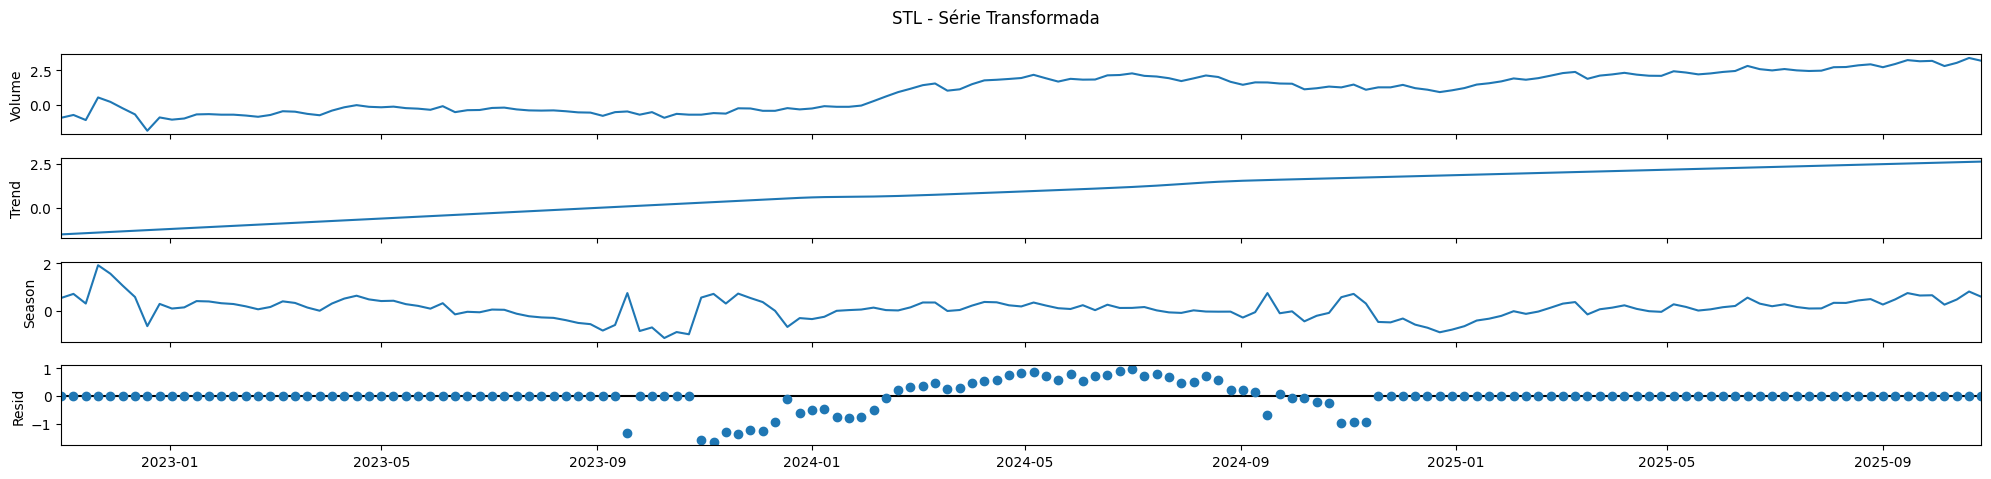

In [121]:
fig = stl_orig.plot()
fig.set_size_inches(20, 5)

plt.suptitle("STL - Série Original", y=0.95)
plt.tight_layout()

axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("Volume")

plt.show()

fig = stl_bc.plot()
fig.set_size_inches(20, 5)
plt.suptitle("STL - Série Transformada", y=0.95)
plt.tight_layout()
axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("Volume")
plt.show()

### Decomposição STL para `inv`


In [122]:
# STL para inv (original)
series_inv_orig = prison["inv"].asfreq(pd.infer_freq(prison.index) or "W")
stl_inv_orig = STL(series_inv_orig, period=52, robust=True).fit()


In [123]:
# STL para inv (transformado - log)
series_inv_log = prison["inv_log"].asfreq(pd.infer_freq(prison.index) or "W")
stl_inv_log = STL(series_inv_log, period=52, robust=True).fit()


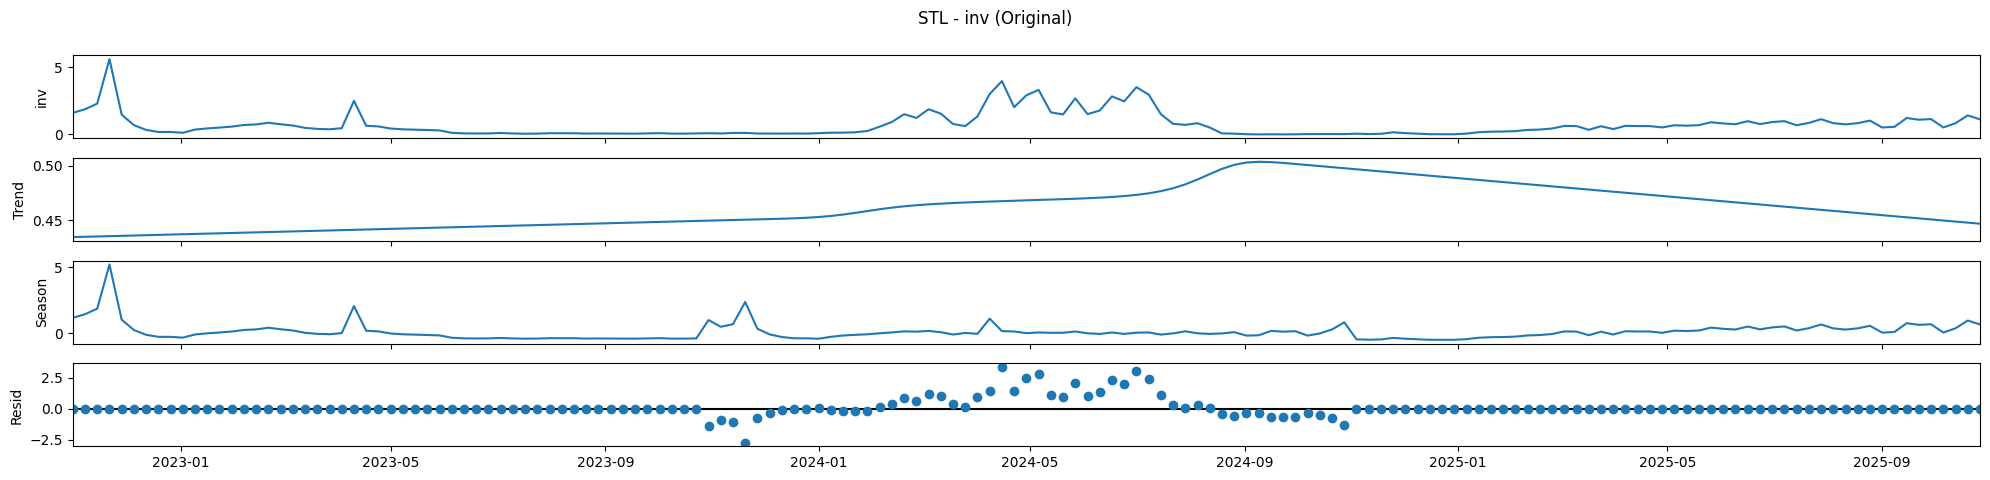

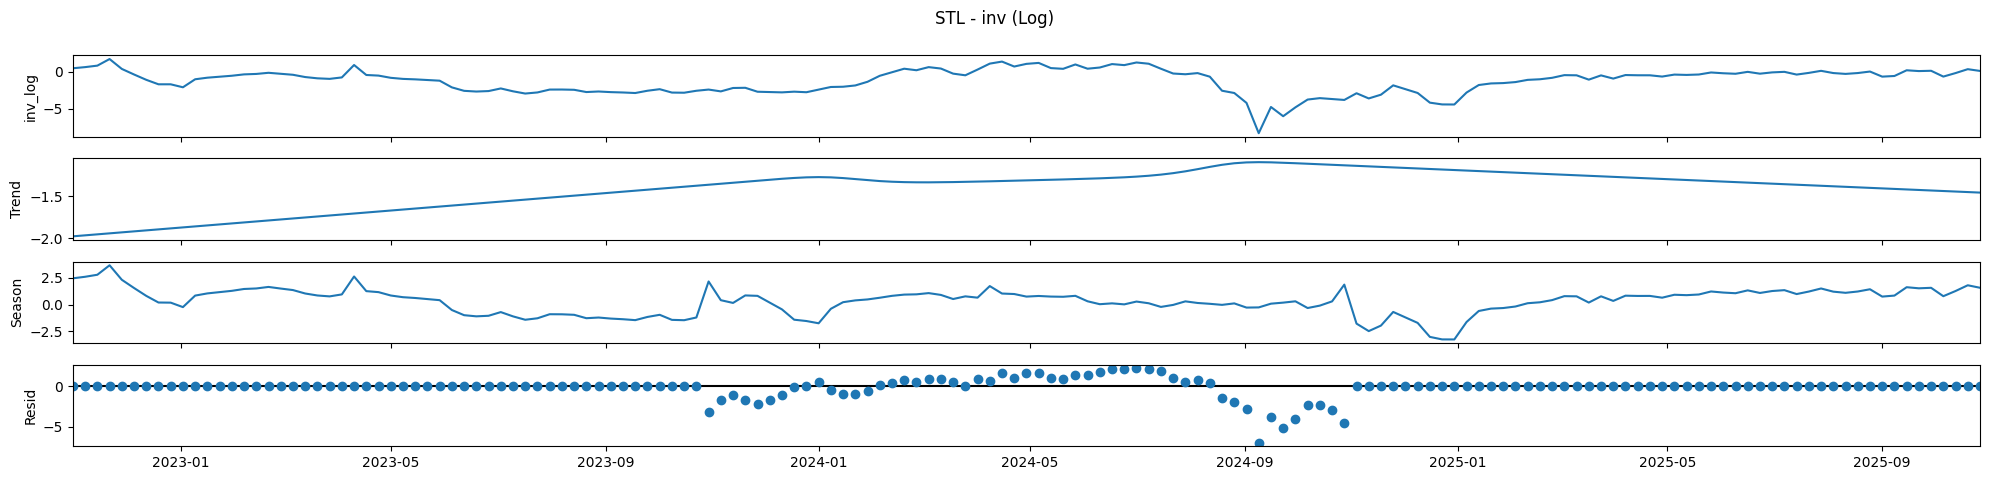

In [124]:
# Plot STL para inv
fig = stl_inv_orig.plot()
fig.set_size_inches(20, 5)

plt.suptitle("STL - inv (Original)", y=0.95)
plt.tight_layout()

axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("inv")

plt.show()

fig = stl_inv_log.plot()
fig.set_size_inches(20, 5)
plt.suptitle("STL - inv (Log)", y=0.95)
plt.tight_layout()
axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("inv_log")
plt.show()


### Decomposição STL para `users`


In [125]:
# STL para users (original)
series_users_orig = prison["users"].asfreq(pd.infer_freq(prison.index) or "W")
stl_users_orig = STL(series_users_orig, period=52, robust=True).fit()


In [126]:
# STL para users (transformado - log)
series_users_log = prison["users_log"].asfreq(pd.infer_freq(prison.index) or "W")
stl_users_log = STL(series_users_log, period=52, robust=True).fit()


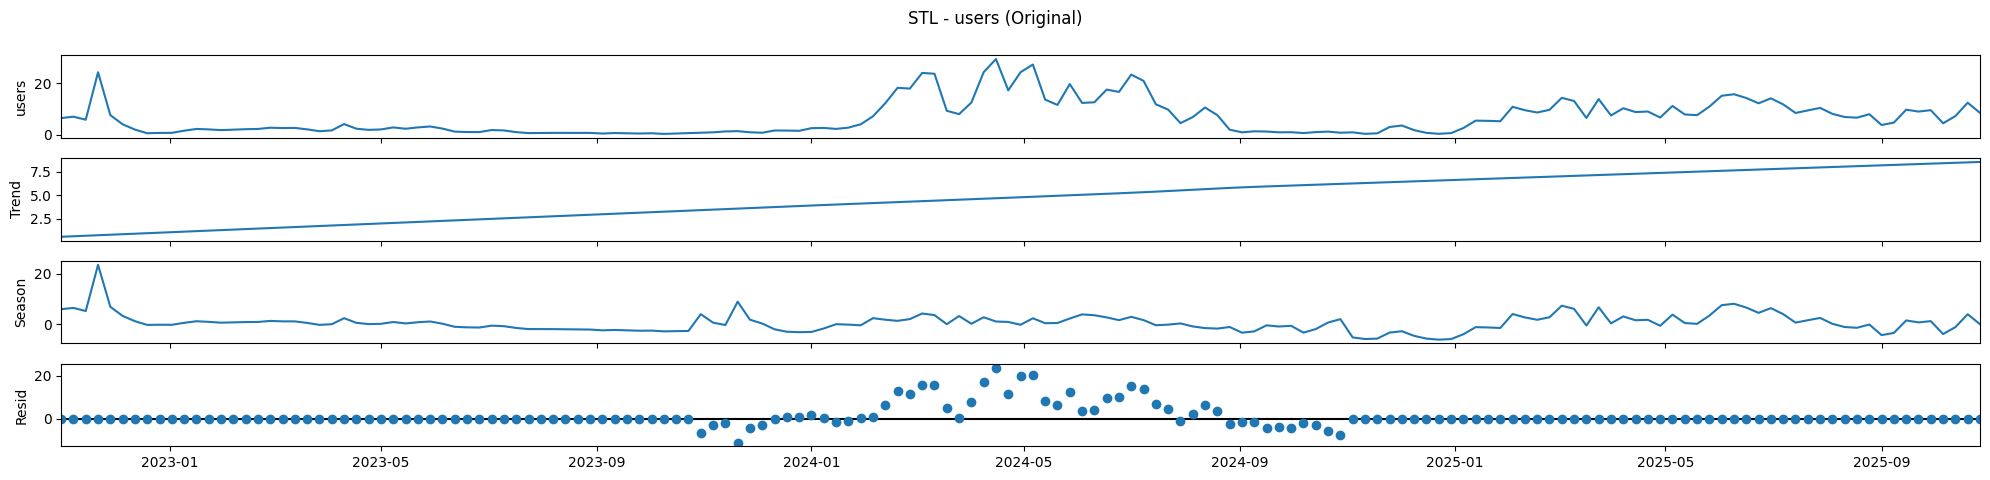

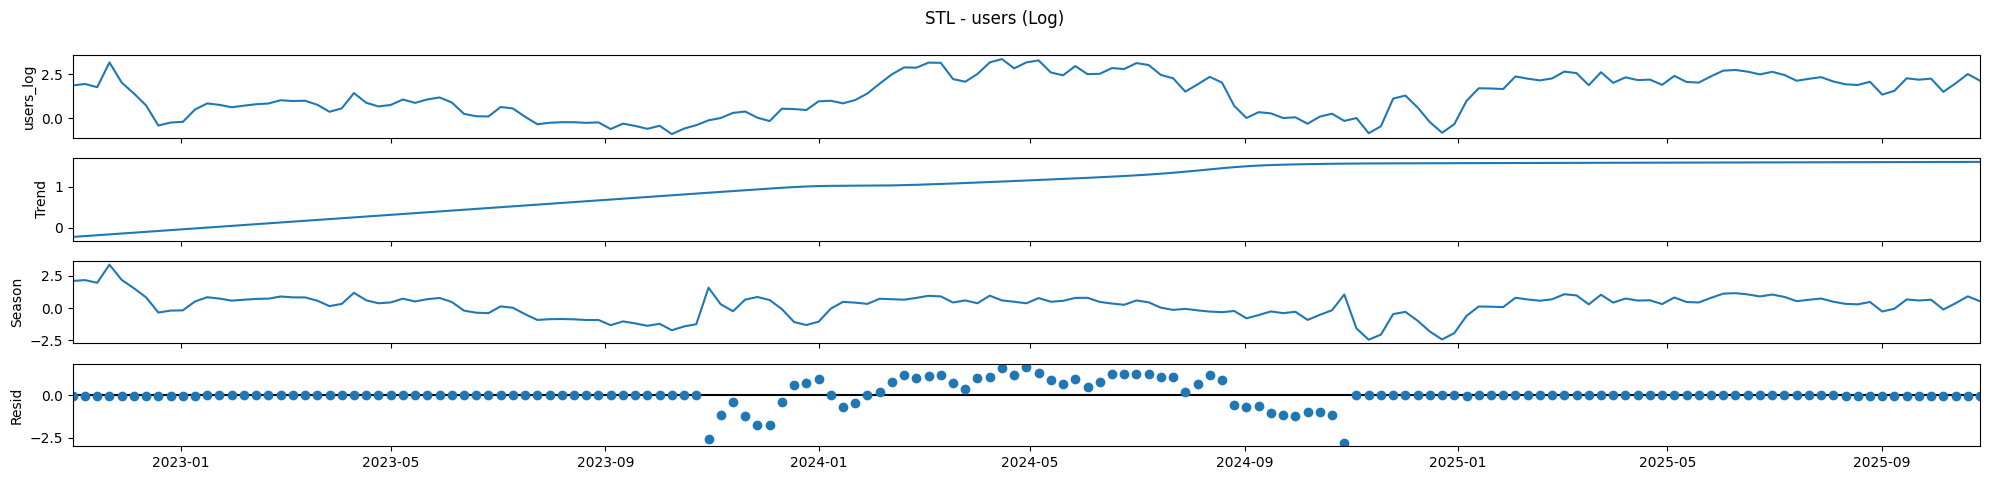

In [127]:
# Plot STL para users
fig = stl_users_orig.plot()
fig.set_size_inches(20, 5)

plt.suptitle("STL - users (Original)", y=0.95)
plt.tight_layout()

axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("users")

plt.show()

fig = stl_users_log.plot()
fig.set_size_inches(20, 5)
plt.suptitle("STL - users (Log)", y=0.95)
plt.tight_layout()
axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("users_log")
plt.show()


# Baselines

In [128]:
y = prison["volume"].sort_index()
y = y.asfreq(pd.infer_freq(y.index) or "W")

h = 52  # horizonte
y_tr, y_te = y.iloc[:-h], y.iloc[-h:]

# ------- Com transformação Box-Cox -------

y_bc = prison["volume_bc"].sort_index()
y_bc = y_bc.asfreq(pd.infer_freq(y_bc.index) or "W")

y_tr_bc, y_te_bc = y_bc.iloc[:-h], y_bc.iloc[-h:]

## Baselines padrão

**Mean**: média simples de todos os dados históricos.

**Naive**: usa simplesmente o último valor observado como previsão.

**Snaive**: usa o último valor observado da mesma estação.

**Drift**: tendência linear baseada no primeiro e no último valor da série.

In [129]:
def fit_pred(strategy, y_tr=y_tr, sp=1):
    fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)
    
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr)
    return f.predict(fh)

def calculate_metrics(name_model, yhat, y_te=y_te):
    mase_metric = MeanAbsoluteScaledError(sp=52)

    y_true_arr = np.asarray(y_te)
    y_pred_arr = np.asarray(yhat)
    y_train_arr = np.asarray(y_tr)

    row = {
        "model": name_model,
        "MAE":  mean_absolute_error(y_true_arr, y_pred_arr),
        "RMSE": mean_squared_error(y_true_arr, y_pred_arr, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100,
        "MASE": mase_metric(y_true_arr, y_pred_arr, y_train=y_train_arr),
    }

    return row

## Modelos de Suavização

**SES (Simple Exponential Smoothing)**: média ponderada dos valores passados, com maior peso nos mais recentes.

**Holt**: extensão do SES que adiciona uma tendência linear suavizada.

**Holt-Winters**: versão completa que incorpora tendência e sazonalidade (aditiva ou multiplicativa).


In [130]:
### SEM TRANSFORMAÇÃO ###

# Suavização Exponencial Simples
ses_model = ExponentialSmoothing(y_tr, trend=None, seasonal=None)
ses_fit = ses_model.fit()
ses_pred = ses_fit.forecast(h)

# Holt
holt_model = ExponentialSmoothing(y_tr, trend="add", seasonal=None)
holt_fit = holt_model.fit()
holt_pred = holt_fit.forecast(h)

# Holt-Winters aditivo 
hw_model = ExponentialSmoothing(y_tr, trend="add", seasonal="add", seasonal_periods=52)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(h)

# Holt-Winters multiplicativo
hw_mul_model = ExponentialSmoothing(y_tr, trend="add", seasonal="mul", seasonal_periods=52)
hw_mul_fit = hw_mul_model.fit()
hw_mul_pred = hw_mul_fit.forecast(h)

### COM TRANSFORMAÇÃO BOX-COX ###

# Suavização Exponencial Simples
ses_model = ExponentialSmoothing(y_tr_bc, trend=None, seasonal=None)
ses_fit = ses_model.fit()
ses_pred_bc = ses_fit.forecast(h)

# Holt
holt_model = ExponentialSmoothing(y_tr_bc, trend="add", seasonal=None)
holt_fit = holt_model.fit()
holt_pred_bc = holt_fit.forecast(h)

# Holt-Winters aditivo 
hw_model = ExponentialSmoothing(y_tr_bc, trend="add", seasonal="add", seasonal_periods=52)
hw_fit = hw_model.fit()
hw_pred_bc = hw_fit.forecast(h)

# Holt-Winters multiplicativo não utilizado na normalização por haver valores =< 0 ao aplicar Box-Cox

## Testando e comparando as Baselines

In [131]:
target_name = y_te.name

# ------- Baselines na escala original -------
preds = {
    "mean":  fit_pred("mean", sp=1),
    "naive": fit_pred("last", sp=1),
    "snaive": fit_pred("last", sp=52),   # sazonal 
    "drift": fit_pred("drift", sp=1),
    "ses": pd.Series(ses_pred, index=y_te.index, name=target_name),
    "Holt": pd.Series(holt_pred, index=y_te.index, name=target_name),
    "Holt-Winters Aditivo": pd.Series(hw_pred, index=y_te.index, name=target_name),
    "Holt-Winters Multiplicativo": pd.Series(hw_mul_pred, index=y_te.index, name=target_name)
}

metrics = []
for name, yhat in preds.items():
    row = calculate_metrics(name, yhat)
    metrics.append(row)

baseline_metrics = pd.DataFrame(metrics).sort_values("RMSE").round(3)

# ------- Baselines após transformação Box-Cox -------

target_name_bc = y_te_bc.name

preds_bc = {
    "mean":  fit_pred("mean", y_tr_bc, sp=1),
    "naive": fit_pred("last", y_tr_bc, sp=1),
    "snaive": fit_pred("last", y_tr_bc, sp=52),
    "drift": fit_pred("drift", y_tr_bc, sp=1),
    "ses": pd.Series(ses_pred_bc, index=y_te_bc.index, name=target_name_bc),
    "Holt": pd.Series(holt_pred_bc, index=y_te_bc.index, name=target_name_bc),
    "Holt-Winters Aditivo": pd.Series(hw_pred_bc, index=y_te_bc.index, name=target_name_bc)
}

metrics_bc = []
for name, yhat_bc in preds_bc.items():
    row = calculate_metrics(name, yhat_bc, y_te_bc)
    metrics_bc.append(row)

baselines_metrics_bc = pd.DataFrame(metrics_bc).sort_values("RMSE").round(3)

# Mostrar as duas tabelas na mesma célula
print("Baselines sem transformação (escala original):")
display(baseline_metrics)

print("\nBaselines com transformação Box-Cox em volume:")
display(baselines_metrics_bc)

Baselines sem transformação (escala original):


,model,MAE,RMSE,MAPE_%,MASE
7,Holt-Winters Multiplicativo,3.793,6.029,33.555,1.101
6,Holt-Winters Aditivo,4.696,6.678,37.938,1.363
2,snaive,5.782,7.422,58.712,1.678
3,drift,5.815,7.570,48.649,1.688
5,Holt,5.815,7.570,48.649,1.688
4,ses,6.538,8.424,54.465,1.898
1,naive,6.538,8.424,54.465,1.898
0,mean,7.526,9.292,66.304,2.185



Baselines com transformação Box-Cox em volume:


,model,MAE,RMSE,MAPE_%,MASE
6,Holt-Winters Aditivo,0.419,0.494,20.252,0.122
5,Holt,0.467,0.530,20.445,0.136
3,drift,0.470,0.533,20.514,0.136
4,ses,0.988,1.150,39.883,0.287
1,naive,0.993,1.156,40.061,0.288
2,snaive,1.080,1.215,57.806,0.313
0,mean,1.928,2.035,85.461,0.560


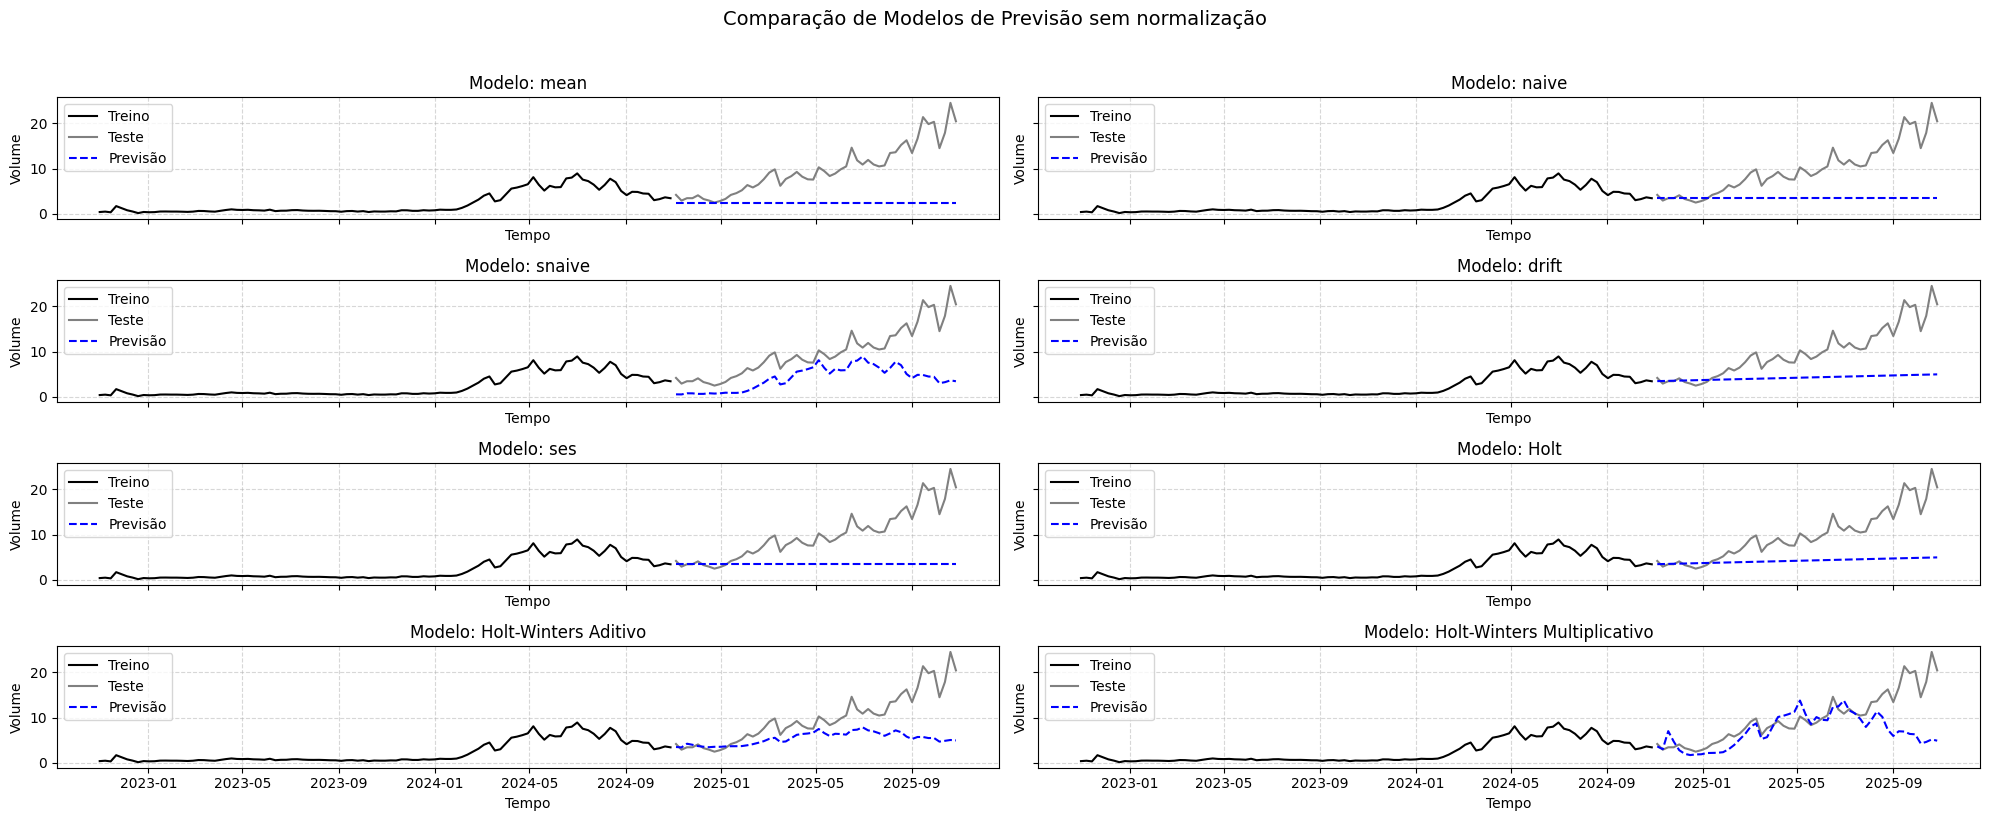

In [132]:
fig, axes = plt.subplots(4, 2, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (name, yhat) in enumerate(preds.items()):
    ax = axes[i]
    # Série observada (treino + teste)
    ax.plot(y_tr.index, y_tr, color="black", label="Treino")
    ax.plot(y_te.index, y_te, color="gray", label="Teste")
    # Previsão
    ax.plot(y_te.index, yhat, color="blue", linestyle="--", label="Previsão")
    
    ax.set_title(f"Modelo: {name}")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Volume")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Comparação de Modelos de Previsão sem normalização", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

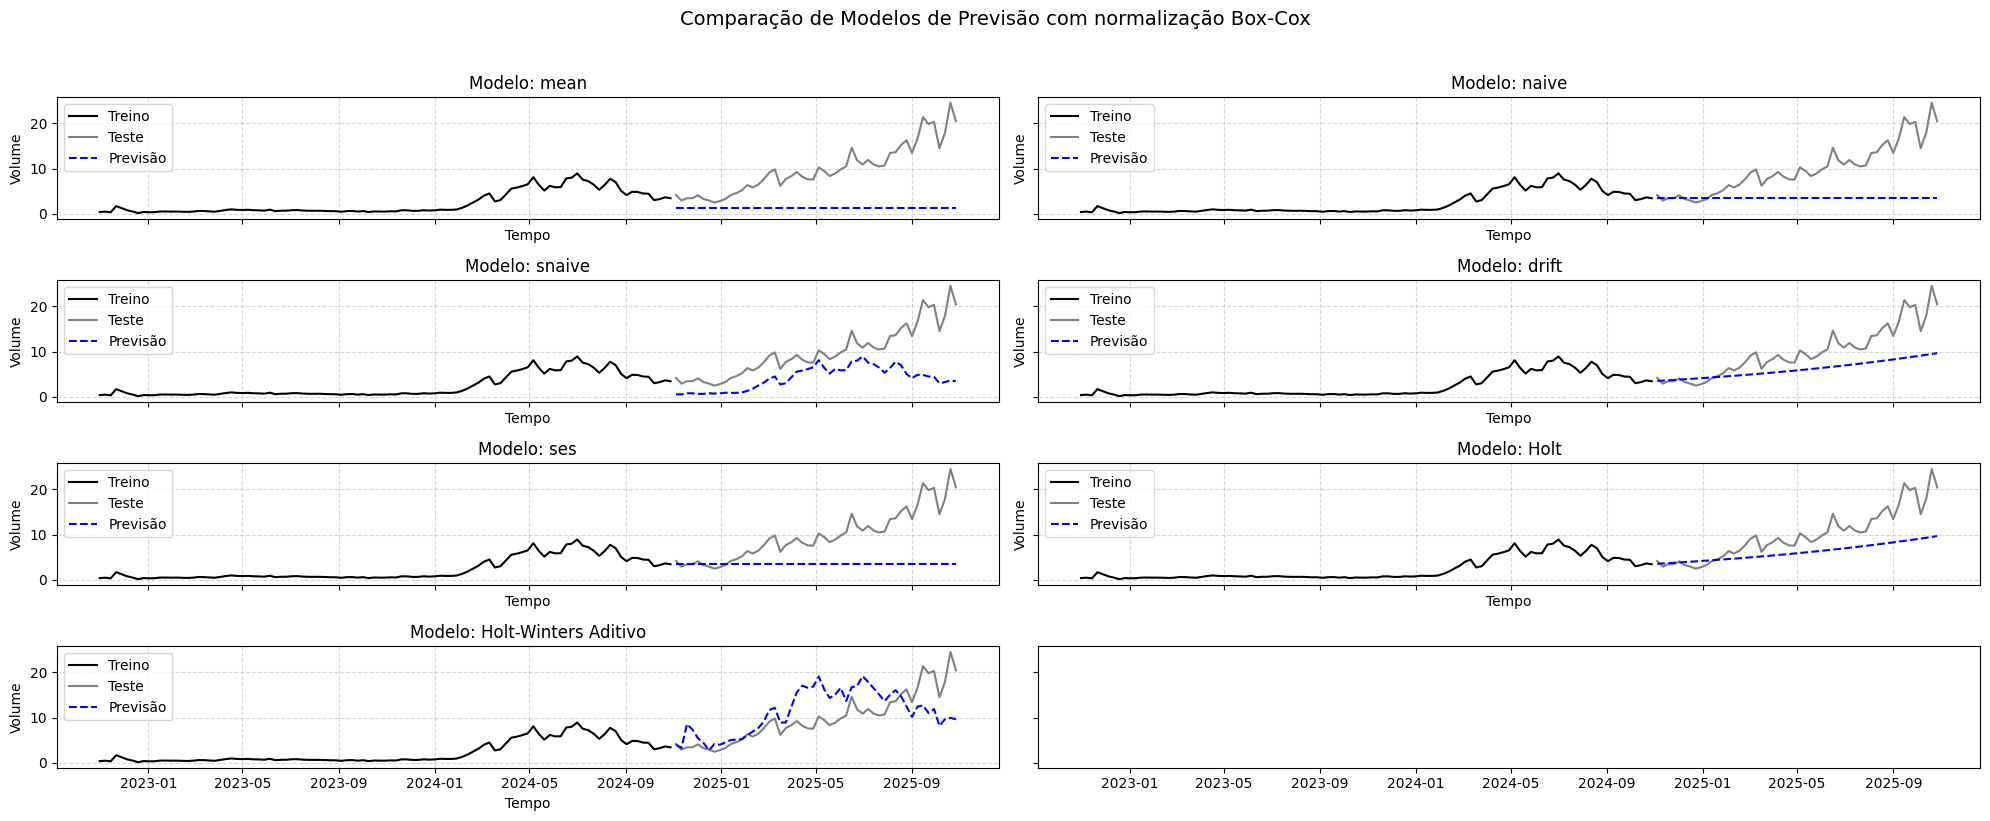

In [133]:
fig, axes = plt.subplots(4, 2, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (name, yhat) in enumerate(preds_bc.items()):
    ax = axes[i]
    # Série observada (treino + teste)
    ax.plot(y_tr_bc.index, inv_boxcox(y_tr_bc, lmbda), color="black", label="Treino")
    ax.plot(y_te_bc.index, inv_boxcox(y_te_bc, lmbda), color="gray", label="Teste")
    # Previsão
    ax.plot(y_te.index, inv_boxcox(yhat, lmbda), color="blue", linestyle="--", label="Previsão")
    
    ax.set_title(f"Modelo: {name}")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Volume")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Comparação de Modelos de Previsão com normalização Box-Cox", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Resíduos

In [134]:
residuos = {name: y_te - yhat for name, yhat in preds.items()}
residuos_bc = {name: y_te_bc - yhat for name, yhat in preds_bc.items()}

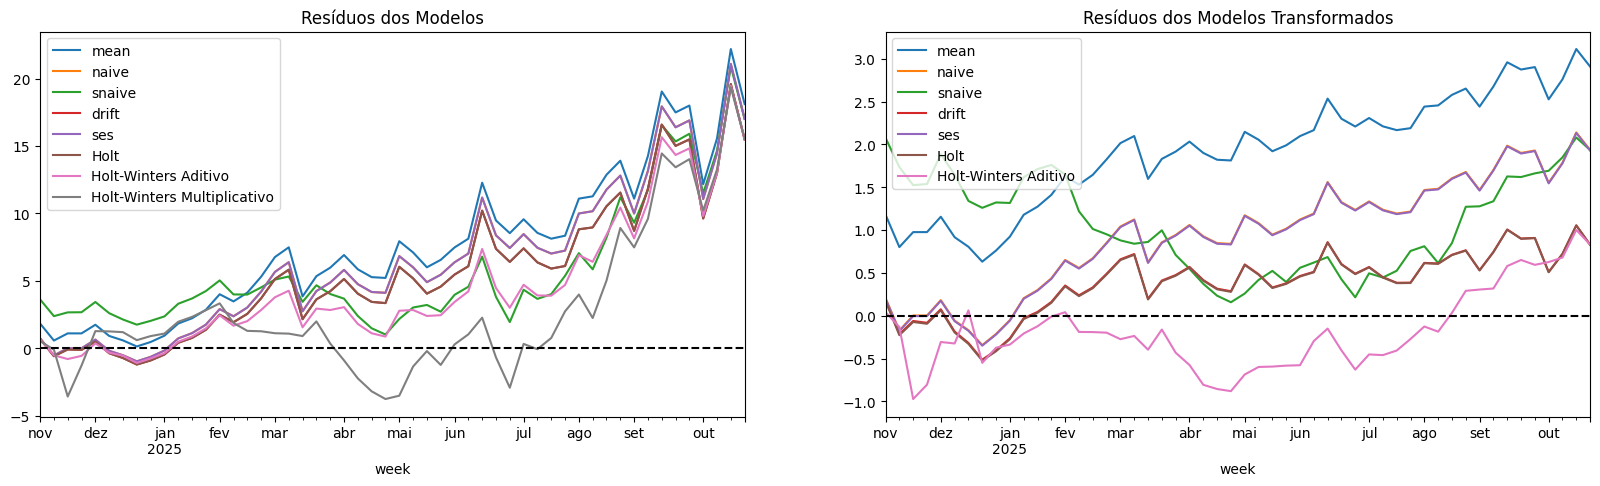

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for name, res in residuos.items():
    res.plot(ax=ax[0], label=name)

for name, res in residuos_bc.items():
    res.plot(ax=ax[1], label=name)

ax[0].axhline(0, color="black", linestyle="--")
ax[0].set_title("Resíduos dos Modelos")
ax[0].legend()

ax[1].axhline(0, color="black", linestyle="--")
ax[1].set_title("Resíduos dos Modelos Transformados")
ax[1].legend()

plt.show()

Após a transformação, os resíduos ficam mais próximos de zero e com menor variabilidade — isso ocorre em todos os modelos.

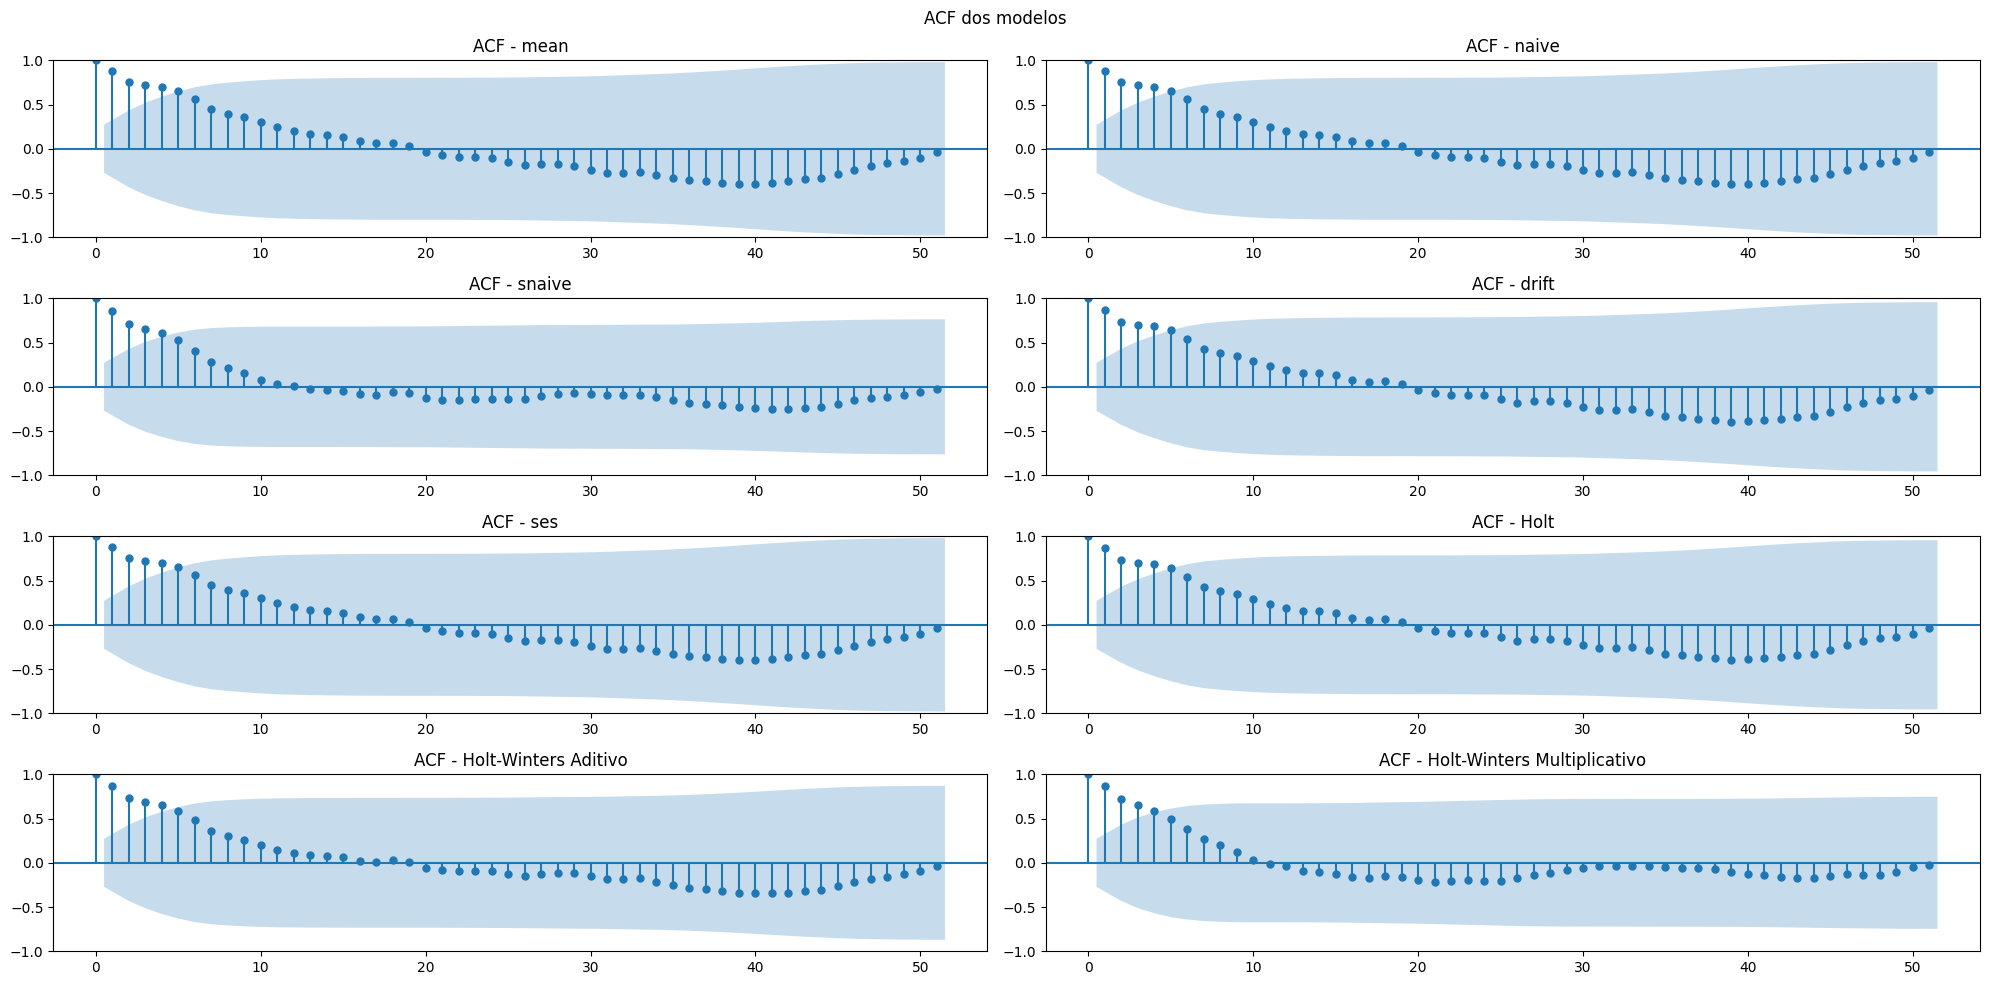

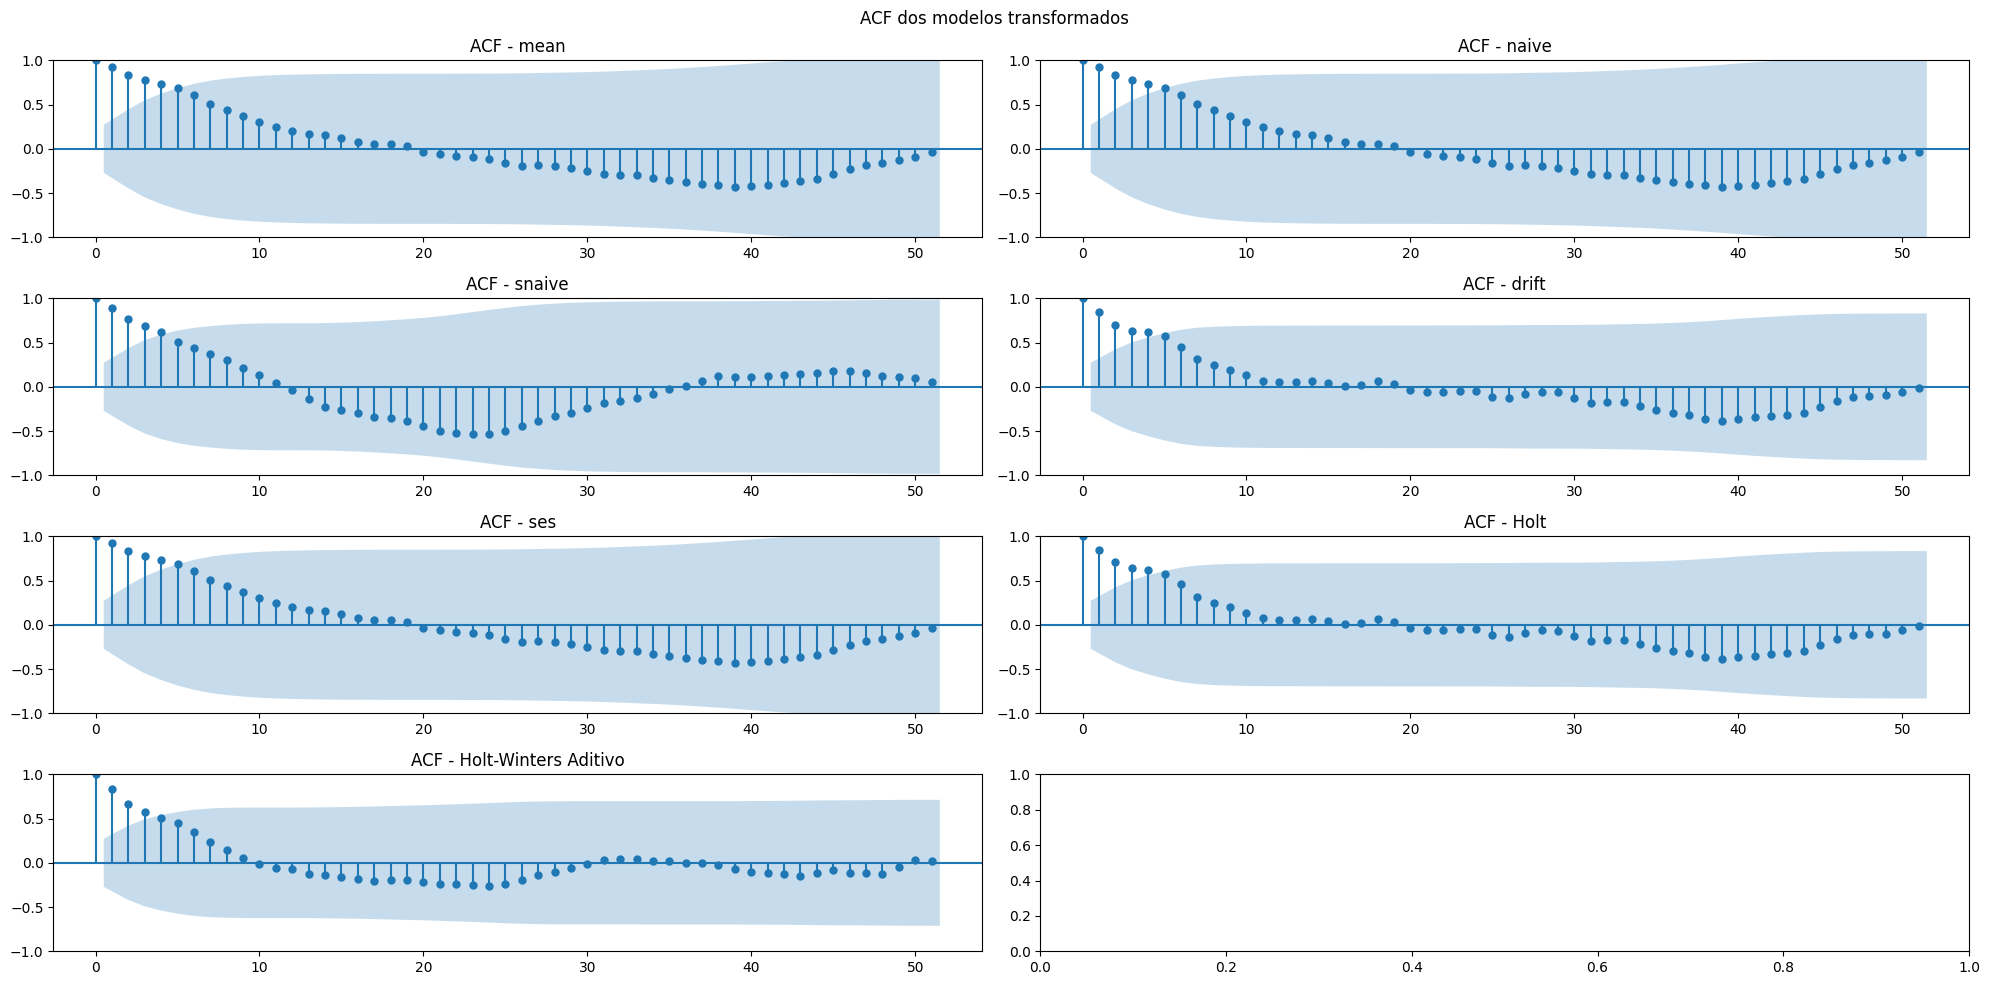

In [136]:
fig, axes = plt.subplots(4, 2, figsize=(20, 10))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    plot_acf(res, lags=h-1, ax=ax)
    ax.set_title(f"ACF - {name}")

plt.suptitle("ACF dos modelos")

plt.tight_layout()

plt.show()

fig, axes = plt.subplots(4, 2, figsize=(20, 10))

for ax, (name, res) in zip(axes.flatten(), residuos_bc.items()):
    plot_acf(res, lags=h-1, ax=ax)
    ax.set_title(f"ACF - {name}")

plt.suptitle("ACF dos modelos transformados")

plt.tight_layout()

plt.show()

FALAR SOBRE

In [137]:
print("Ljung-Box p-value dos modelos")
for name, res in residuos.items():
    lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
    print(f"{name}: {lb_test["lb_pvalue"].values[0]}")

print("\n")
print("Ljung-Box p-value dos modelos transformados")
for name, res in residuos_bc.items():
    lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
    print(f"{name}: {lb_test["lb_pvalue"].values[0]}")

Ljung-Box p-value dos modelos
mean: 1.4120923873991498e-40
naive: 1.412092387399231e-40
snaive: 2.0972274004772817e-27
drift: 1.9786406628217115e-38
ses: 1.412092387399231e-40
Holt: 1.978562934305797e-38
Holt-Winters Aditivo: 3.330643023907362e-33
Holt-Winters Multiplicativo: 1.6519568365396074e-26


Ljung-Box p-value dos modelos transformados
mean: 5.1636937498817445e-47
naive: 5.163693749881889e-47
snaive: 9.767115478282066e-32
drift: 9.888839102592548e-29
ses: 5.163693749881889e-47
Holt: 4.810939762857619e-29
Holt-Winters Aditivo: 1.793485119488993e-21


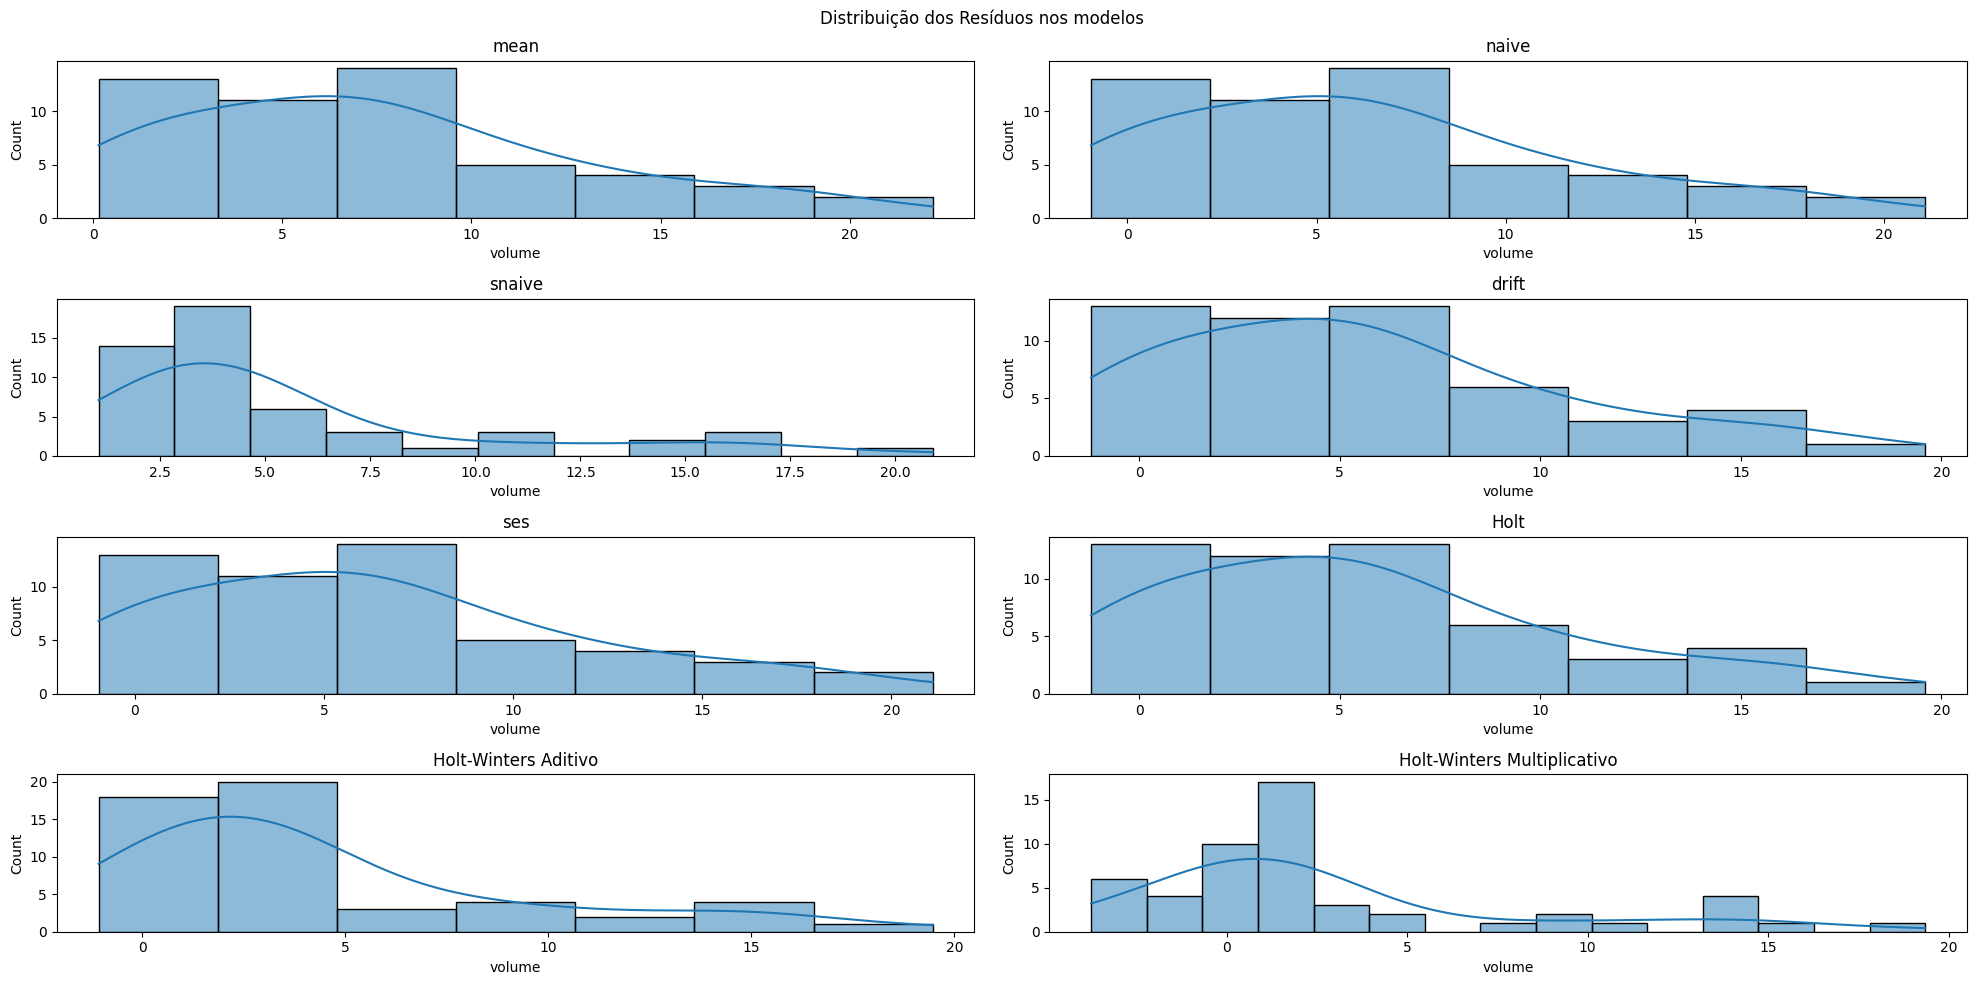

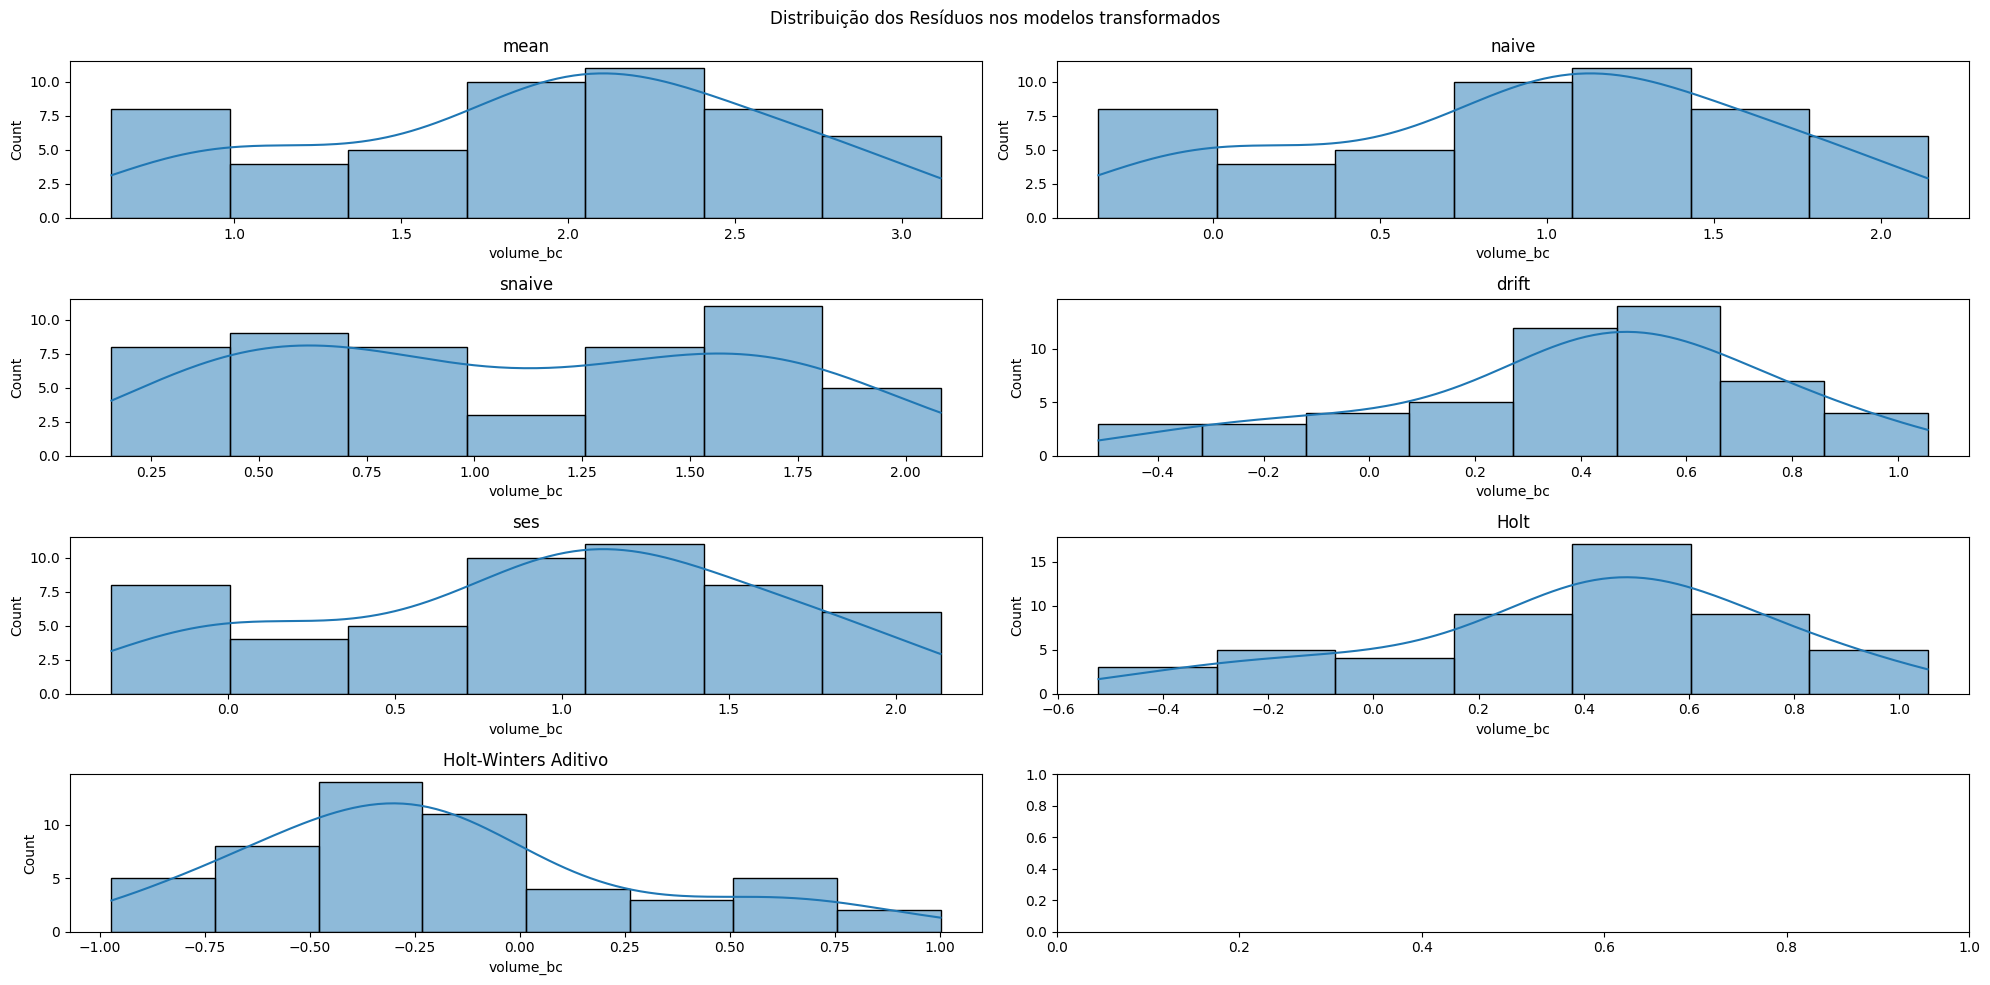

In [138]:
fig, axes = plt.subplots(4, 2, figsize=(20, 10))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(name)

plt.suptitle("Distribuição dos Resíduos nos modelos")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(20, 10))

for ax, (name, res) in zip(axes.flatten(), residuos_bc.items()):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(name)
    
plt.suptitle("Distribuição dos Resíduos nos modelos transformados")
plt.tight_layout()
plt.show()

FALAR SOBRE

# Modelagem com ARIMA e SARIMA

A partir daqui, em todo o notebook, usaremos y já com a transformação Box-Cox

In [139]:
y_tr, y_te = y_bc.iloc[:-h], y_bc.iloc[-h:]

In [140]:
# `prison` já está indexado por `week`, então usamos apenas o índice atual
X = prison[["inv", "users"]].sort_index()
X = X.asfreq(pd.infer_freq(y.index) or "W")

h = 52

X_tr, X_te = X.loc[y_tr.index], X.loc[y_te.index]

# ------- X após normalização log-------

X_norm = prison[["inv_log", "users_log"]].sort_index()
X_norm = X_norm.asfreq(pd.infer_freq(y.index) or "W")

h = 52

X_tr_norm, X_te_norm = X_norm.loc[y_tr.index], X_norm.loc[y_te.index]

ARIMA

In [141]:
# escolha inicial de (p, d, q)
d = 1  # diferenciar para remover tendência
p, q = 1, 1  # ponto de partida simples
# Futuramente podemos fazer um grid search para ver quais os melhores parametros
arima = ARIMA(y_tr, order=(p, d, q)).fit()

arima_pred = arima.forecast(h)

arima_metrics = calculate_metrics("ARIMA", arima_pred, y_te)
metrics_bc.append(arima_metrics)

pd.DataFrame([arima_metrics])

,model,MAE,RMSE,MAPE_%,MASE
0,ARIMA,0.976843,1.137003,39.520191,0.574502


SARIMA

In [142]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52)

sarima = SARIMAX(y_tr, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit()
sarima_pred = sarima.forecast(steps=h)

sarima_metrics = calculate_metrics("SARIMA", sarima_pred, y_te)
metrics_bc.append(sarima_metrics)

sarima_metrics = pd.DataFrame([sarima_metrics]).round(3)
sarima_metrics

c:\Users\casti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,model,MAE,RMSE,MAPE_%,MASE
0,SARIMA,0.92,1.07,43.108,0.541


SARIMAX

In [143]:
# Sem normalização nas variáveis exógenas
sarimax = SARIMAX(
    y_tr,
    exog=X_tr,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

sarimax_pred = sarimax.forecast(steps=h, exog=X_te)
sarimax_pred = pd.Series(sarimax_pred, index=y_te.index, name=y_te.name)

sarimax_metrics = calculate_metrics("SARIMAX", sarimax_pred, y_te)
metrics_bc.append(sarimax_metrics)

# Com normalização nas variáveis exógenas
sarimax_norm = SARIMAX(
    y_tr,
    exog=X_tr_norm,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

sarimax_pred_norm = sarimax.forecast(steps=h, exog=X_te_norm)
sarimax_pred_norm = pd.Series(sarimax_pred_norm, index=y_te.index, name=y_te.name)

sarimax_norm_metrics = calculate_metrics("SARIMAX Norm", sarimax_pred_norm, y_te)
metrics_bc.append(sarimax_norm_metrics)


sarimax_metrics = pd.DataFrame([sarimax_metrics, sarimax_norm_metrics]).round(3)
sarimax_metrics

c:\Users\casti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\casti\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,model,MAE,RMSE,MAPE_%,MASE
0,SARIMAX,0.876,0.977,40.687,0.515
1,SARIMAX Norm,0.724,0.808,35.578,0.426


In [144]:
metrics = pd.DataFrame(metrics_bc).sort_values("RMSE").reset_index().drop(columns="index").round(3)
metrics

,model,MAE,RMSE,MAPE_%,MASE
0,Holt-Winters Aditivo,0.419,0.494,20.252,0.122
1,Holt,0.467,0.530,20.445,0.136
2,drift,0.470,0.533,20.514,0.136
3,SARIMAX Norm,0.724,0.808,35.578,0.426
4,SARIMAX,0.876,0.977,40.687,0.515
5,SARIMA,0.920,1.070,43.108,0.541
6,ARIMA,0.977,1.137,39.520,0.575
7,ses,0.988,1.150,39.883,0.287
8,naive,0.993,1.156,40.061,0.288
9,snaive,1.080,1.215,57.806,0.313


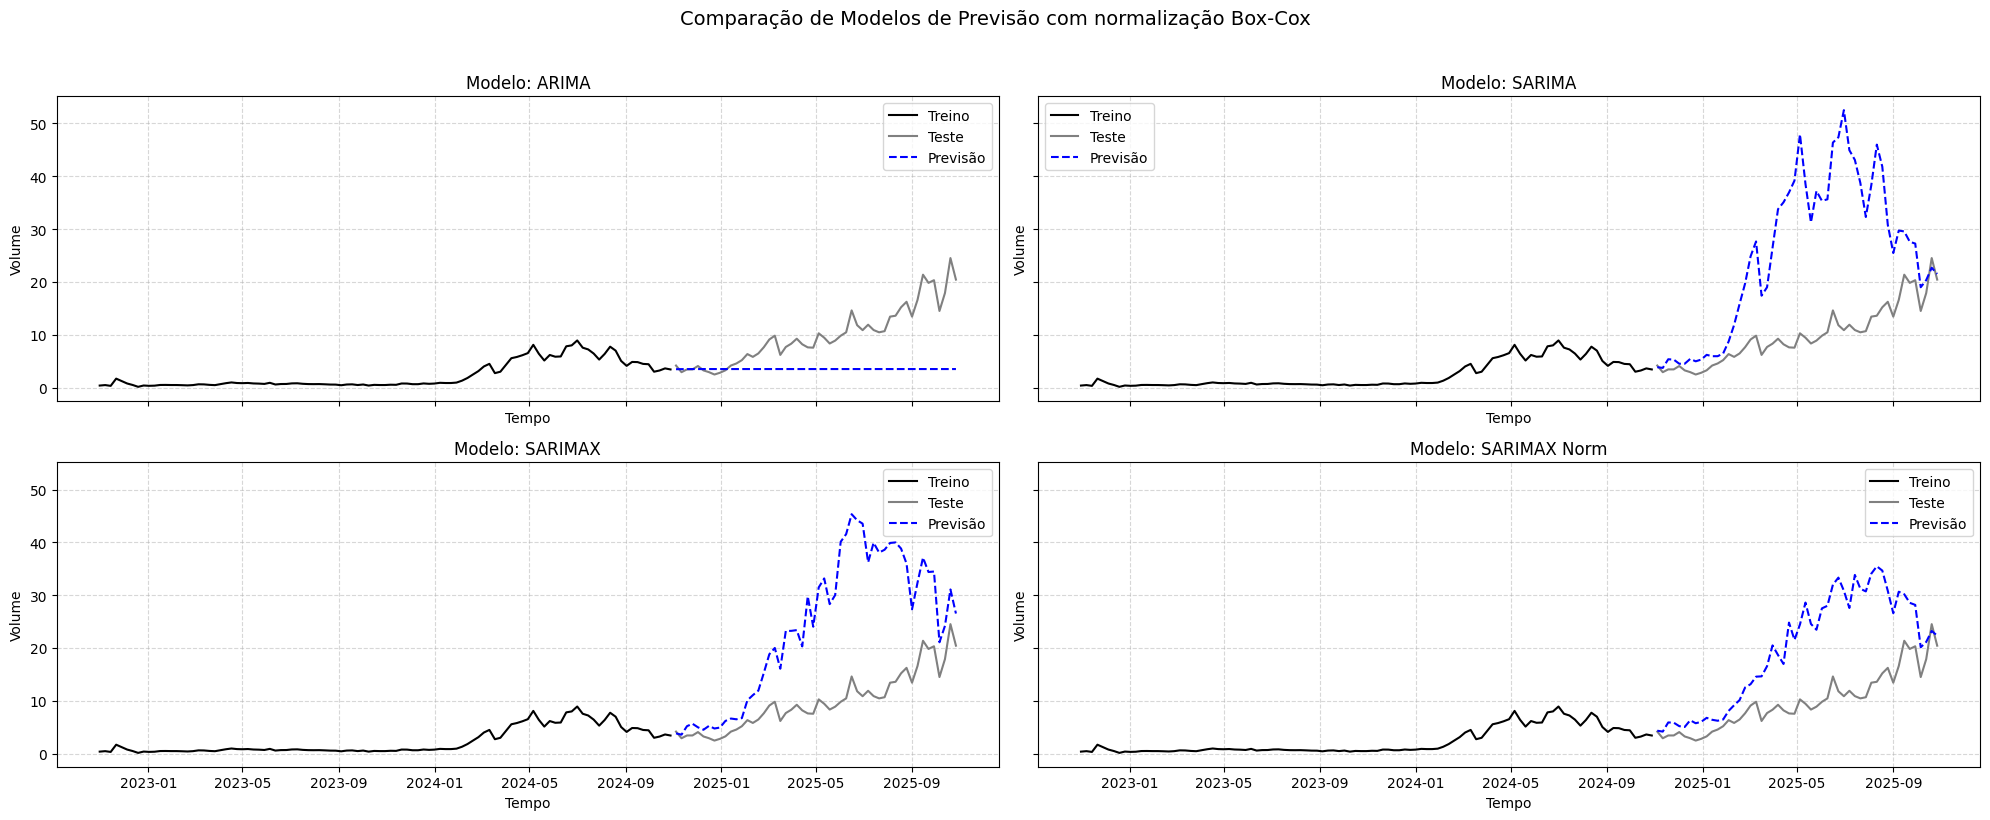

In [ ]:
preds = {"ARIMA": arima_pred, 
         "SARIMA": sarima_pred, 
         "SARIMAX": sarimax_pred, 
         "SARIMAX Norm": sarimax_pred_norm}

fig, axes = plt.subplots(2, 2, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (name, yhat) in enumerate(preds.items()):
    ax = axes[i]
    # Série observada (treino + teste)
    ax.plot(y_tr.index, inv_boxcox(y_tr, lmbda), color="black", label="Treino")
    ax.plot(y_te.index, inv_boxcox(y_te, lmbda), color="gray", label="Teste")
    # Previsão
    ax.plot(y_te.index, inv_boxcox(yhat, lmbda), color="blue", linestyle="--", label="Previsão")
    
    ax.set_title(f"Modelo: {name}")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Volume")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Comparação de Modelos de Previsão", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Medindo Correlações

In [36]:
corr_pearson_matrix = prison[["volume", "inv", "users"]].corr("pearson")
corr_spearman_matrix = prison[["volume", "inv", "users"]].corr("spearman")
cross_corr_us_x_vol = sm.tsa.stattools.ccf(y, X["users"], adjusted=False)[:20]  # até 20 defasagens
cross_corr_inv_x_vol = sm.tsa.stattools.ccf(y, X["inv"], adjusted=False)[:20]

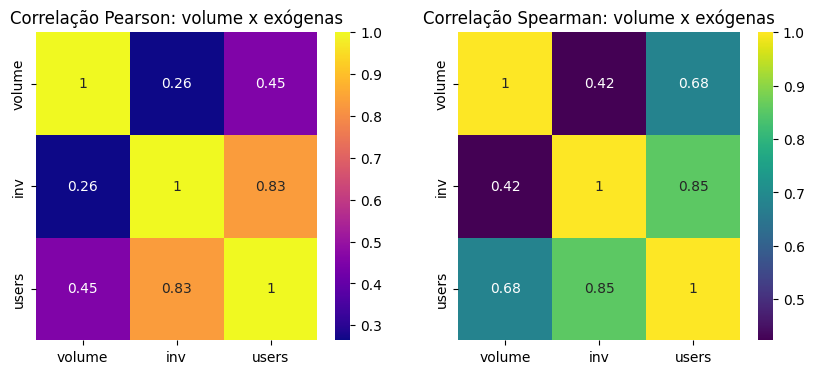

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(corr_pearson_matrix, ax=axes[0], annot=True, cmap="plasma")
axes[0].set_title("Correlação Pearson: volume x exógenas")

sns.heatmap(corr_spearman_matrix, ax=axes[1], annot=True, cmap="viridis")
axes[1].set_title("Correlação Spearman: volume x exógenas")

plt.show()

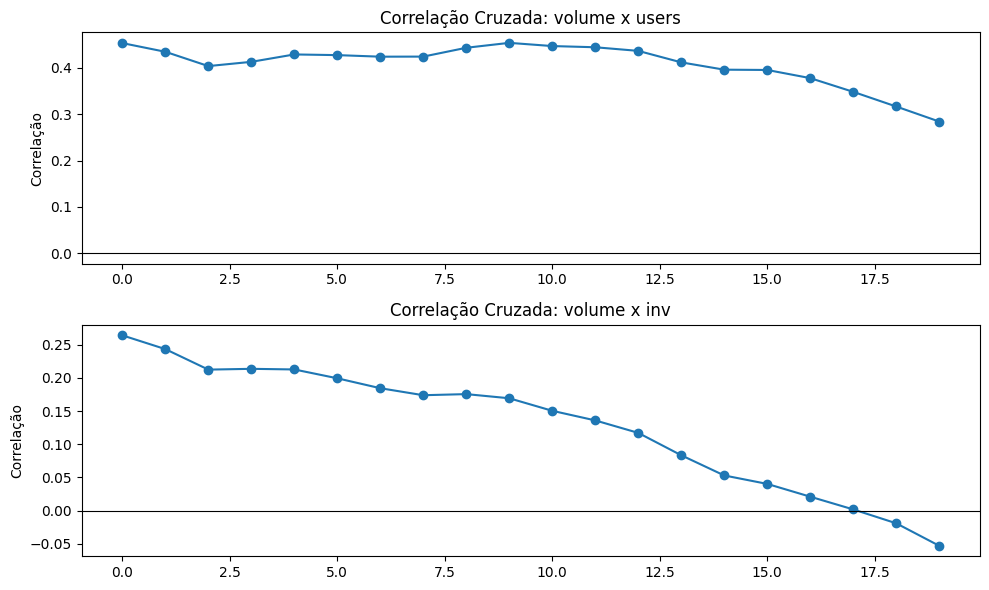

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# cross-correlation até 20 defasagens
cross_corr_us_x_vol = sm.tsa.stattools.ccf(y, X["users"], adjusted=False)[:20]
cross_corr_inv_x_vol = sm.tsa.stattools.ccf(y, X["inv"], adjusted=False)[:20]

axes[0].plot(range(len(cross_corr_us_x_vol)), cross_corr_us_x_vol, marker="o")
axes[0].axhline(0, color="black", linewidth=0.8)
axes[0].set_title("Correlação Cruzada: volume x users")
axes[0].set_ylabel("Correlação")

axes[1].plot(range(len(cross_corr_inv_x_vol)), cross_corr_inv_x_vol, marker="o")
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_title("Correlação Cruzada: volume x inv")
axes[1].set_ylabel("Correlação")

plt.tight_layout()
plt.show()


# Modelo de Regressão

Aplica-se validação cruzada temporal (5 folds), respeitando a ordem cronológica para evitar vazamento de informação

In [39]:
# CV temporal
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

def cv_score_for_subset(subset, y, metric, *args):
    X_sub = subset.values
    scores = []
    for train_index, val_index in tscv.split(X_sub):
        X_tr, X_val = X_sub[train_index], X_sub[val_index]
        y_tr, y_val = y.values[train_index], y.values[val_index]

        model = LinearRegression()
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict(X_val)

        if args is not None:
            scores.append(metric(y_val, y_pred, square_root=args))
        else:
            scores.append(metric(y_val, y_pred))

    return np.mean(scores), np.std(scores)

A partir dos resultados dos modelos anteriores, sabemos que a modelagem melhora ao utilizar as normalizações, tanto na variável de interesse (transformação Box-Cox) quanto nas variáveis exógenas (Transformação log)

In [40]:
# Criando dataframe para a regressão
df = prison.reset_index().copy()
df["volume"] = df["volume_bc"]
df["inv"] = df["inv_log"]
df["users"] = df["users_log"]

df = df.drop(columns=["volume_bc", "inv_log", "users_log"])

Variáveis criadas a partir de `volume`

In [41]:
# Extrai features temporais
df["year"] = df["week"].dt.year
df["month"] = df["week"].dt.month
df["weekofyear"] = df["week"].dt.isocalendar().week.astype(int)

# Criar defasagens (lags)
df["lag1"] = df["volume"].shift(1)
df["lag2"] = df["volume"].shift(2)
df["lag52"] = df["volume"].shift(52)  # captura sazonalidade anual

# Cria médias móveis
df["rolling_mean_4"] = df["volume"].shift(1).rolling(4).mean()
df["rolling_mean_12"] = df["volume"].shift(1).rolling(12).mean()

Variáveis criadas a partir das variáveis exógenas de prison

In [42]:
# Defasagens
df["inv_lag1"] = df["inv"].shift(1)
df["inv_lag4"] = df["inv"].shift(4)
df["users_lag1"] = df["users"].shift(1)
df["users_lag4"] = df["users"].shift(4)

# Médias móveis
df["inv_roll4"] = df["inv"].shift(1).rolling(4).mean()
df["users_roll4"] = df["users"].shift(1).rolling(4).mean()

# Cresciemnto/diferenças
df["inv_diff"] = df["inv"].diff()
df["users_diff"] = df["users"].diff()

df["inv_pct_change"] = df["inv"].pct_change()
df["users_pct_change"] = df["users"].pct_change()


Interações das variáveis também podem ser úteis

In [43]:
df["inv_x_users"] = df["inv"] * df["users"]
df["volume_x_users"] = df["volume"] * df["users"]
df["volume_x_inv"] = df["volume"] * df["inv"]

In [44]:
# Removendo possíveis NaNs
df = df.dropna()
df

,week,volume,inv,users,year,month,weekofyear,lag1,lag2,lag52,...,users_lag4,inv_roll4,users_roll4,inv_diff,users_diff,inv_pct_change,users_pct_change,inv_x_users,volume_x_users,volume_x_inv
52,2023-10-30,-0.723805,-2.413711,-0.124430,2023,10,44,-0.723805,-0.664784,-0.949972,...,-0.436956,-2.651056,-0.587639,0.163241,0.277541,-0.063346,-0.690450,0.300338,0.090063,1.747056
53,2023-11-06,-0.609012,-2.661929,0.006976,2023,11,45,-0.723805,-0.723805,-0.744270,...,-0.913794,-2.663902,-0.509508,-0.248219,0.131406,0.102837,-1.056061,-0.018569,-0.004248,1.621147
54,2023-11-13,-0.645850,-2.200375,0.300845,2023,11,46,-0.609012,-0.723805,-1.115064,...,-0.597837,-2.623767,-0.279316,0.461554,0.293869,-0.173391,42.128113,-0.661972,-0.194301,1.421113
55,2023-11-20,-0.260068,-2.173270,0.378436,2023,11,47,-0.645850,-0.609012,0.530007,...,-0.401971,-2.463242,-0.054645,0.027105,0.077591,-0.012318,0.257911,-0.822445,-0.098419,0.565198
56,2023-11-27,-0.273008,-2.708018,0.026642,2023,11,48,-0.260068,-0.645850,0.207832,...,-0.124430,-2.362321,0.140457,-0.534748,-0.351795,0.246057,-0.929600,-0.072147,-0.007273,0.739309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2025-09-29,3.191674,0.134831,2.259156,2025,9,40,3.163194,3.247683,1.529004,...,1.347294,-0.233675,1.847622,0.040504,0.058050,0.429400,0.026373,0.304605,7.210489,0.430338
153,2025-10-06,2.815073,-0.653379,1.504966,2025,10,41,3.191674,3.163194,1.121921,...,1.562975,-0.035144,2.075587,-0.788211,-0.754190,-5.845898,-0.333837,-0.983313,4.236589,-1.839310
154,2025-10-13,3.048625,-0.176739,1.987326,2025,10,42,2.815073,3.191674,1.199055,...,2.279112,-0.055395,2.061085,0.476640,0.482360,-0.729500,0.320512,-0.351238,6.058613,-0.538811
155,2025-10-20,3.402597,0.352235,2.522363,2025,10,43,3.048625,2.815073,1.321410,...,2.201106,-0.150240,1.988138,0.528974,0.535037,-2.992966,0.269224,0.888464,8.582585,1.198513


Definindo X e y do modelo.

Inicialmente, X possui todas as variáveis exceto `volume` (variáveis exógenas e derivadas).

In [ ]:
X = df[[
    "inv","users","inv_x_users", "volume_x_users",
    "volume_x_inv","year","month","weekofyear",
    "lag1","lag2","lag52",#"rolling_mean_4","rolling_mean_12",
    "inv_lag1","users_lag1",#"inv_roll4","users_roll4",
    "inv_diff","users_diff"
]]

y = df["volume"]

In [46]:
h = 52

X_train, X_test = X.iloc[:-h].copy(), X.iloc[-h:].copy()
y_train, y_test = y.iloc[:-h].copy(), y.iloc[-h:].copy()

# Adiciona intercepto
X_train = sm.add_constant(X_train)
X_test["const"] = np.ones(X_test.shape[0])
X_test = X_test[X_train.columns]

cols = X.columns.tolist()

Primeiro vamos fazer uma regressão apenas com as variáveis exógenas

In [47]:
simple_model = sm.OLS(y_train, X_train[["inv", "users"]]).fit()

pred_res = simple_model.get_prediction(X_test[["inv", "users"]])
summary = pred_res.summary_frame()

pred_means = summary["mean"].values
pred_lower = summary["mean_ci_lower"].values
pred_upper = summary["mean_ci_upper"].values
pred_index = X_test.index.tolist()

# converte para arrays / séries alinhadas por índice
y_pred = pd.Series(pred_means, index=pred_index).sort_index().values
pred_lower = pd.Series(pred_lower, index=pred_index).sort_index()
pred_upper = pd.Series(pred_upper, index=pred_index).sort_index()

residuos_best = y_test - y_pred

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, square_root=True))
print(simple_model.summary())

MAE:  0.98962843669814
RMSE:  1.1178378128518311
                                 OLS Regression Results                                
Dep. Variable:                 volume   R-squared (uncentered):                   0.763
Model:                            OLS   Adj. R-squared (uncentered):              0.754
Method:                 Least Squares   F-statistic:                              82.29
Date:                Mon, 01 Dec 2025   Prob (F-statistic):                    1.09e-16
Time:                        19:09:12   Log-Likelihood:                         -56.830
No. Observations:                  53   AIC:                                      117.7
Df Residuals:                      51   BIC:                                      121.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025     

In [48]:
# busca exaustiva (todas as combinações)
results = []
for k in range(1, len(cols)):
    for subset in itertools.combinations(cols, k):
        mean_MAE_score, std_MAE_score = cv_score_for_subset(X[list(subset)], y, mean_absolute_error)
        mean_RMSE_score, std_RMSE_score = cv_score_for_subset(X[list(subset)], y, mean_squared_error, False)
        results.append({
            "subset": subset,
            "k": k,
            "mean MAE": mean_MAE_score,
            "std MAE": std_MAE_score,
            "mean RMSE": mean_RMSE_score,
            "std RMSE": std_RMSE_score
        })

res_df = pd.DataFrame(results).sort_values("mean MAE")
res_df

,subset,k,mean MAE,std MAE,mean RMSE,std RMSE
1839,"(month, lag1, lag2, users_diff)",4,0.117983,0.025670,0.156067,0.030729
1783,"(year, lag1, lag2, users_diff)",4,0.118075,0.029347,0.155983,0.036805
4821,"(month, weekofyear, lag1, lag2, users_diff)",5,0.118086,0.025566,0.156218,0.030690
1414,"(inv_x_users, lag1, lag2, users_diff)",4,0.118163,0.030901,0.155897,0.035070
544,"(lag1, lag2, users_diff)",3,0.118609,0.030414,0.155918,0.035891
...,...,...,...,...,...,...
426,"(volume_x_inv, month, users_diff)",3,2.156537,1.975226,2.372186,2.248211
1694,"(volume_x_inv, weekofyear, inv_diff, users_diff)",4,2.167793,1.953791,2.392276,2.231474
1673,"(volume_x_inv, month, inv_diff, users_diff)",4,2.169630,1.971453,2.397209,2.256261
1652,"(volume_x_inv, month, weekofyear, users_diff)",4,2.190333,1.934078,2.447721,2.174801


In [58]:
best_features = list(res_df.iloc[0]["subset"])
best_features

['month', 'lag1', 'lag2', 'users_diff']

In [59]:
pred_means = list()
pred_lower = list()
pred_upper = list()
pred_index = list()

X_loop = X[best_features].copy()

for h in range(4, 53, 4):
    n_forecast = 56 - h
    if n_forecast > 4:
        X_train, X_test = X_loop.iloc[:-n_forecast].copy(), X_loop.iloc[-n_forecast:-n_forecast + 4].copy()
        y_train, y_test = y.iloc[:-n_forecast].copy(), y.iloc[-n_forecast: -n_forecast + 4].copy()
    else:
        X_train, X_test = X_loop.iloc[:-4].copy(), X_loop.iloc[-n_forecast:].copy()
        y_train, y_test = y.iloc[:-4].copy(), y.iloc[-n_forecast:].copy()

    X_train = sm.add_constant(X_train)
    X_test["const"] = np.ones(X_test.shape[0])
    X_test = X_test[X_train.columns]
    model = sm.OLS(y_train, X_train).fit()

    pred_res = model.get_prediction(X_test)
    summary = pred_res.summary_frame()
    
    pred_means.extend(summary["mean"].values)
    pred_lower.extend(summary["mean_ci_lower"].values)
    pred_upper.extend(summary["mean_ci_upper"].values)
    pred_index.extend(X_test.index.tolist())

# converte para arrays / séries alinhadas por índice
y_pred = pd.Series(pred_means, index=pred_index).sort_index().values
pred_lower = pd.Series(pred_lower, index=pred_index).sort_index()
pred_upper = pd.Series(pred_upper, index=pred_index).sort_index()

In [60]:
y_test = y.iloc[-52:]

residuos = y_pred - y_test

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, square_root=True))
print(model.summary())

MAE:  0.11353090660804274
RMSE:  0.1579308911321089
                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1131.
Date:                seg, 01 dez 2025   Prob (F-statistic):           8.30e-80
Time:                        19:19:33   Log-Likelihood:                 56.315
No. Observations:                 101   AIC:                            -102.6
Df Residuals:                      96   BIC:                            -89.55
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


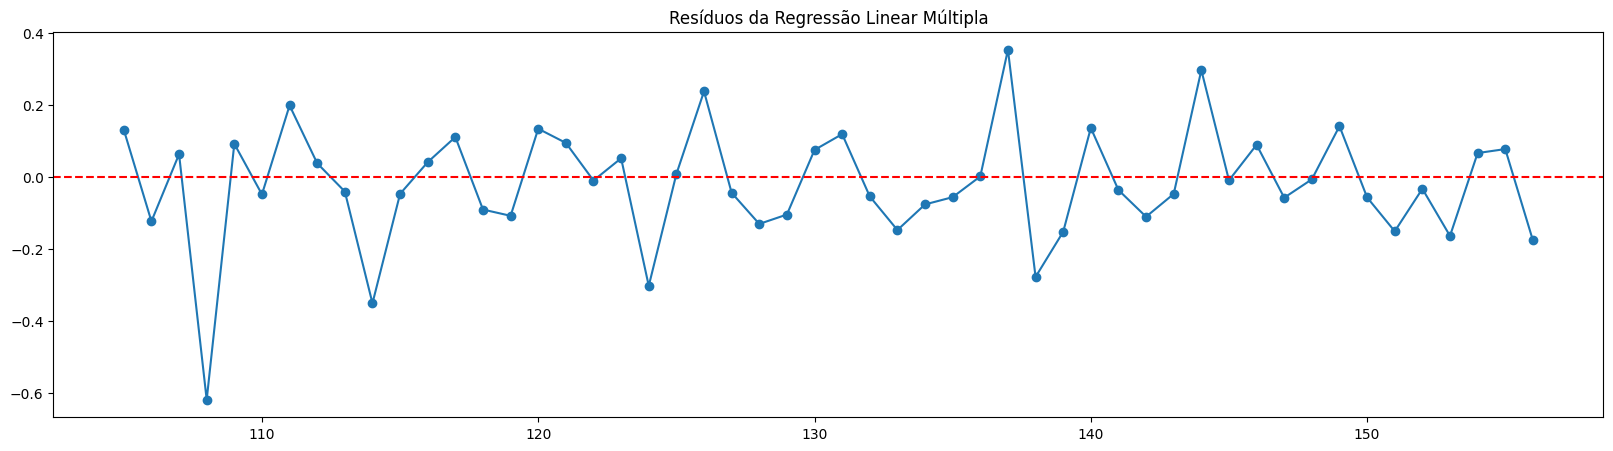

In [61]:
plt.figure(figsize=(20,5))

plt.plot(residuos_best, marker="o")

plt.axhline(0, color="red", linestyle="--")
plt.title("Resíduos da Regressão Linear Múltipla")
plt.show()

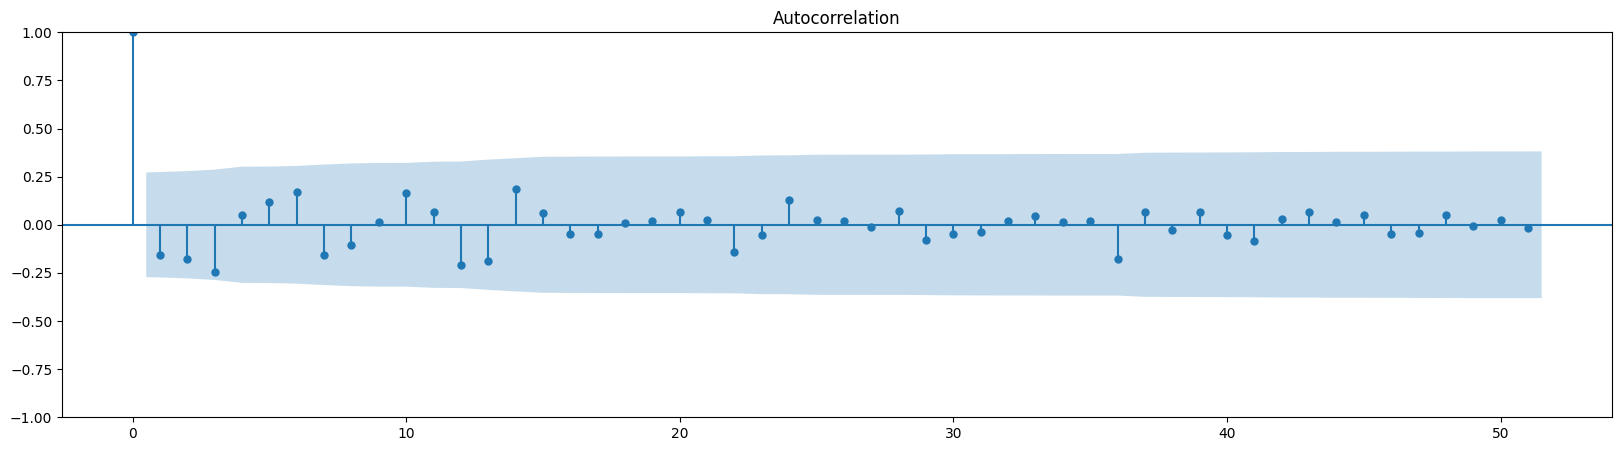

In [62]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_acf(residuos_best, lags=residuos_best.shape[0] - 1, ax=ax)

plt.show()

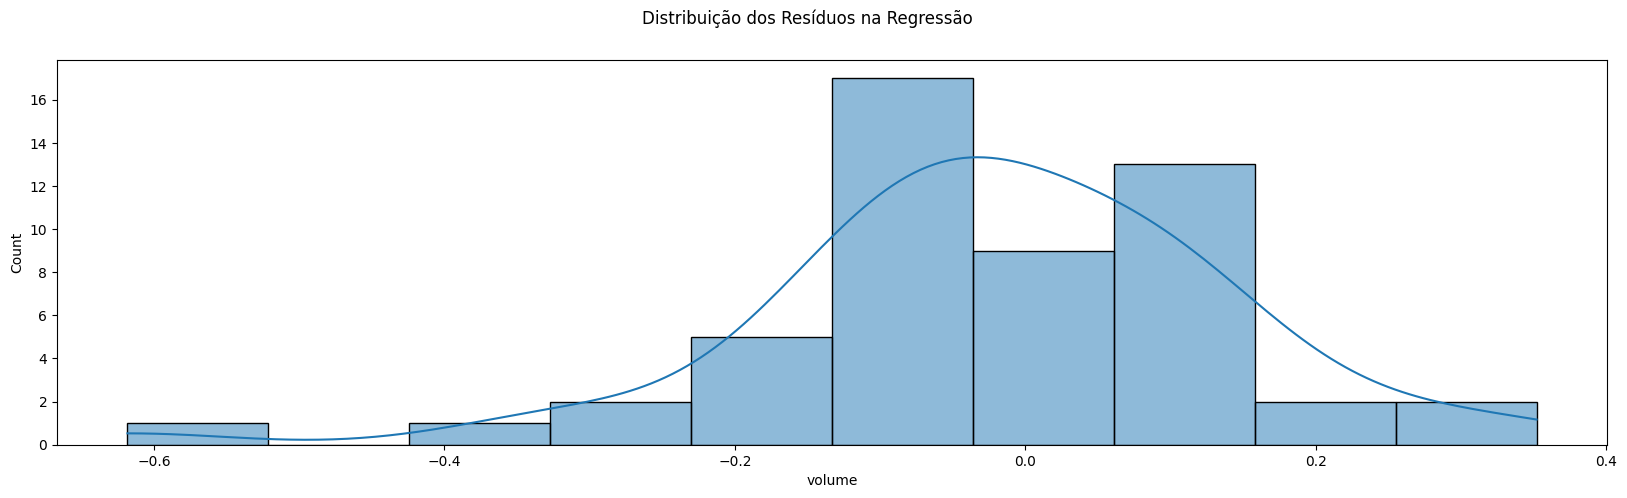

In [63]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.histplot(residuos_best, kde=True, ax=ax)

plt.suptitle("Distribuição dos Resíduos na Regressão")

plt.show()

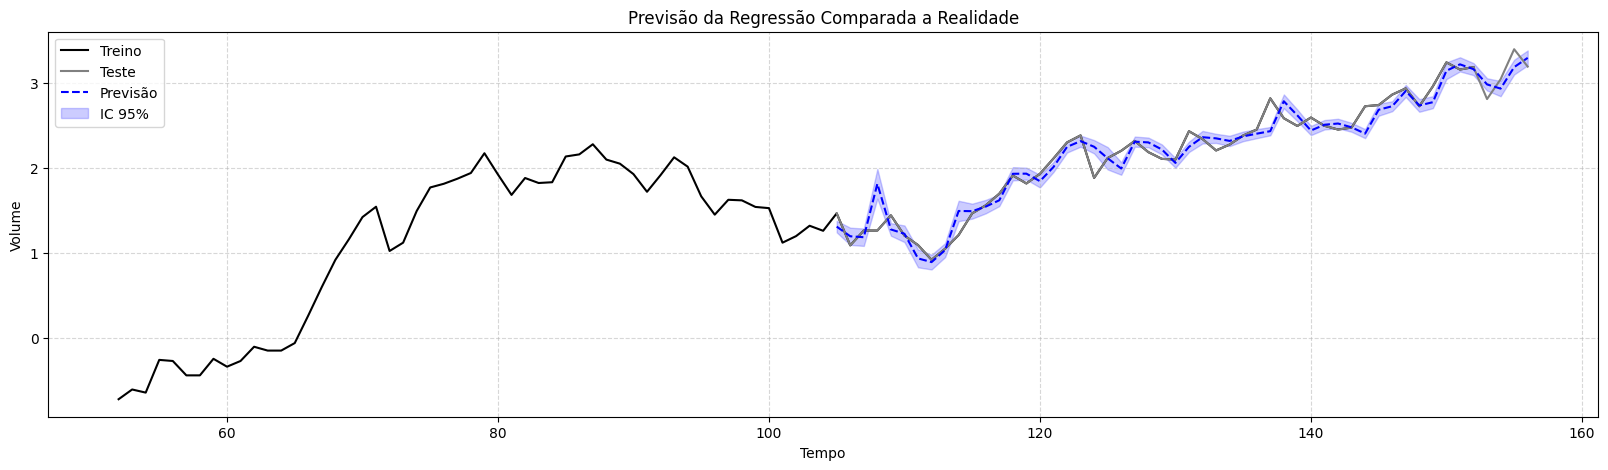

In [64]:
# Cria um grid 2x2 de subplots
plt.figure(figsize=(20, 5))

plt.plot(y_train.index, y_train, color="black", label="Treino")
plt.plot(y_test.index, y_test, color="gray", label="Teste")

plt.plot(y_test.index, y_pred, color="blue", linestyle="--", label="Previsão")
    
# intervalo de confiança
plt.fill_between(y_test.index, pred_lower.values, pred_upper.values,
                 color="blue", alpha=0.2, label="IC 95%")
    
plt.title("Previsão da Regressão Comparada a Realidade")
plt.xlabel("Tempo")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.show()